In this file, you can find the code for the Minimisation of the logdet function via the subgradient method and the ZO solvers with exact and approximate queries of the Lovasz Extension. Then, the offline semi-supervised clustering is solved using the subgradient and the ZO solvers with exact and approximate queries of the Lovasz Extension. The goal was to see the performance of the ZO solvers with queries of different approximations of the Lovasz extension. Then, the problem of online semi-supervised clustering is solved using the subgradient and the ZO solvers with exact and approximate queries.

Below the Logdet cost function is defined and the minimisation problem is solved using subgradeitn method with exact and low-rank approximations of kernel matrix, ZO solver with exact Lovasz extension queries, queries with low-rank approximation of the kernel, stochastic query of the Lovasz extension, and query of the Taylor surrogate of the Loavsz Extension.

Running ZO methods comparison...
Running ZO with lowrank_lovasz...
  lowrank_lovasz: 16.51s, final obj: -34.6158
Running ZO with taylor...
  taylor: 1.99s, final obj: -33.5587
Running ZO with stochastic_lovasz...
  stochastic_lovasz: 8.41s, final obj: -33.3934

Running subgradient method...
Subgradient: 3.14s, final obj: -34.6721
Subgradient_approx: 2.99s, final obj: -34.6721


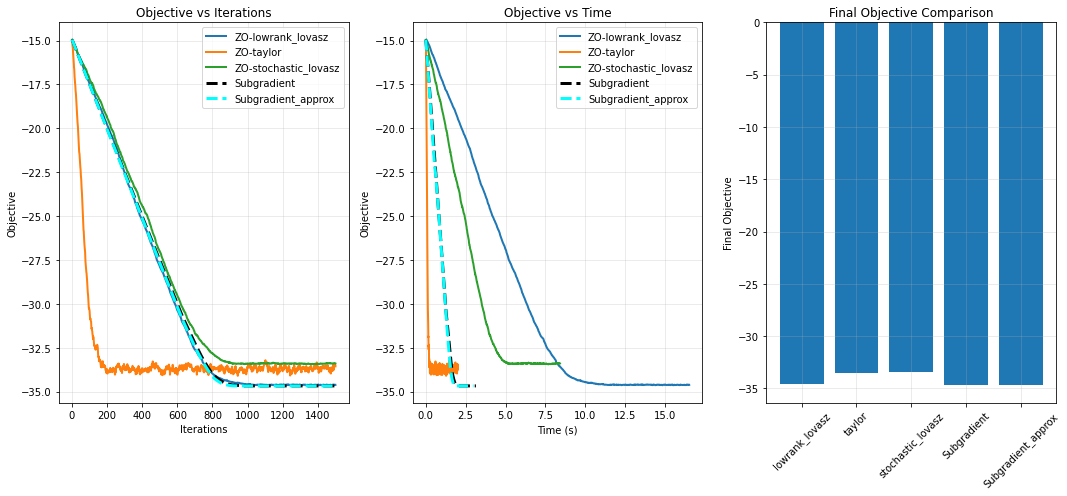


SUMMARY
lowrank_lovasz      : -34.6158 (time:  16.51s)
taylor              : -33.5587 (time:   1.99s)
stochastic_lovasz   : -33.3934 (time:   8.41s)
Subgradient         : -34.6721 (time:   3.14s)

Best ZO method: lowrank_lovasz (-34.6158)
Subgradient: -34.6721
Subgradient: -34.6721
Improvement: -0.0563 (lower is better)


In [340]:
import numpy as np
import time
import matplotlib.pyplot as plt
from numpy.linalg import slogdet, inv, cholesky

# ----------------------------
# Submodular function: logdet with regularization
# ----------------------------
def submodular_logdet(S, K, delta=0.1, alpha=1.0):
    """F(S) = log det(δI + K[S,S]) - α|S|"""
    if len(S) == 0:
        return 0.0
    Ksub = K[np.ix_(S, S)]
    sign, logdet_val = slogdet(delta * np.eye(len(S)) + Ksub)
    return float(logdet_val) - alpha * len(S)

# ----------------------------
# Better Cheap Approximations for ZO
# ----------------------------

def low_rank_lovasz(w, K_lowrank, delta=0.1, alpha=1.0):
    """Cheap Lovász extension using low-rank kernel"""
    n = len(w)
    perm = np.argsort(-w)
    w_sorted = w[perm]
    w_next = np.concatenate([w_sorted[1:], [0.0]])
    diffs = w_sorted - w_next
    
    total = 0.0
    
    for i in range(n):
        Si = perm[:i+1]
        if len(Si) == 0:
            val = 0.0
        else:
            Ksub = K_lowrank[np.ix_(Si, Si)]
            try:
                L = cholesky(delta * np.eye(len(Si)) + Ksub)
                logdet_val = 2 * np.sum(np.log(np.diag(L)))
            except:
                sign, logdet_val = slogdet(delta * np.eye(len(Si)) + Ksub)
            val = float(logdet_val) - alpha * len(Si)
        total += diffs[i] * val
    return total

def taylor_surrogate(w, K, delta=0.1, alpha=1.0, order=2):
    """Taylor expansion surrogate"""
    n = len(w)
    W_sqrt = np.sqrt(np.clip(w, 1e-8, 1.0))
    K_w = W_sqrt[:, None] * K * W_sqrt[None, :]
    
    if order == 1:
        surrogate = np.trace(K_w) / delta
    else:  # order == 2
        trace1 = np.trace(K_w) / delta
        K_w2 = K_w @ K_w
        trace2 = np.trace(K_w2) / (2 * delta**2)
        surrogate = trace1 - trace2
    
    # Add regularization
    return surrogate - alpha * np.sum(w)



def nystrom_corrected_surrogate(w, K_nys, K_full_diag, delta=0.1, alpha=1.0, correction_weight=0.3):
    """Balanced surrogate using diagonal correction"""
    quadratic = w @ (K_nys @ w)
    diagonal = w @ (K_full_diag * w)
    surrogate = (1 - correction_weight) * quadratic + correction_weight * diagonal
    return surrogate - alpha * np.sum(w)

def stochastic_lovasz(w, K, delta=0.1, alpha=1.0, sample_ratio=0.4):
    """Randomly sample prefixes for Lovász extension"""
    n = len(w)
    perm = np.random.permutation(n)
    w_perm = w[perm]
    sort_idx = np.argsort(-w_perm)
    perm_sorted = perm[sort_idx]
    w_sorted = w_perm[sort_idx]
    
    w_next = np.concatenate([w_sorted[1:], [0.0]])
    diffs = w_sorted - w_next
    
    total = 0.0
    sample_points = np.linspace(0, n-1, int(n * sample_ratio), dtype=int)
    
    prev_val = 0.0
    last_idx = 0
    for idx in sample_points:
        Si = perm_sorted[:idx+1]
        if len(Si) > 0:
            Ksub = K[np.ix_(Si, Si)]
            sign, logdet_val = slogdet(delta * np.eye(len(Si)) + Ksub)
            val = float(logdet_val) - alpha * len(Si)
            total += np.sum(diffs[last_idx:idx+1]) * val
            prev_val = val
            last_idx = idx + 1
    
    return total

# ----------------------------
# Exact Lovász extension
# ----------------------------
def exact_lovasz(w, K, delta=0.1, alpha=1.0):
    """Exact Lovász extension"""
    n = len(w)
    perm = np.argsort(-w)
    w_sorted = w[perm]
    w_next = np.concatenate([w_sorted[1:], [0.0]])
    diffs = w_sorted - w_next
    total = 0.0
    
    for i in range(n):
        Si = perm[: i+1]
        val = submodular_logdet(list(Si), K, delta, alpha)
        total += diffs[i] * val
    return float(total)

# ----------------------------
# Subgradient oracles
# ----------------------------
def lovasz_subgradient(w, K, delta=0.1, alpha=1.0):
    """Exact subgradient"""
    n = len(w)
    perm = np.argsort(-w)
    g = np.zeros(n, dtype=float)
    prev_val = 0.0
    
    for k in range(1, n+1):
        Sk = perm[:k]
        val = submodular_logdet(list(Sk), K, delta, alpha)
        marginal = val - prev_val
        g[perm[k-1]] = marginal
        prev_val = val
    return g

def lovasz_subgradient_approx(w, K_approx, delta=0.1, alpha=1.0):
    """Approximate subgradient using low-rank kernel"""
    n = len(w)
    perm = np.argsort(-w)
    g = np.zeros(n)
    prev_val = 0.0
    
    for k in range(1, n+1):
        Sk = perm[:k]
        # Use low-rank kernel for subgradient computation
        Ksub = K_approx[np.ix_(Sk, Sk)]
        sign, logdet_val = slogdet(delta * np.eye(len(Sk)) + Ksub)
        val = float(logdet_val) - alpha * len(Sk)
        marginal = val - prev_val
        g[perm[k-1]] = marginal
        prev_val = val
    return g

# ----------------------------
# Improved ZO Optimizers
# ----------------------------

def ZO_optimizer(w0, K_approx, K_full, delta=0.1, alpha=1.0, steps=1000, 
                mu=1e-3, base_alpha=0.01, m_samples=15, method='lowrank_lovasz'):
    """
    ZO optimizer with better approximations
    """
    n = len(w0)
    w = w0.copy()
    traj_obj = []
    times = []
    start = time.time()
    
    # Precompute for efficient surrogates
    K_diag = np.diag(K_full)
    
    for t in range(1, steps + 1):
        g_sum = np.zeros_like(w)
        
        # Choose surrogate function
        if method == 'lowrank_lovasz':
            f_w = low_rank_lovasz(w, K_approx, delta, alpha)
        elif method == 'taylor':
            f_w = taylor_surrogate(w, K_approx, delta, alpha, order=2)
        elif method == 'nystrom_corrected':
            f_w = nystrom_corrected_surrogate(w, K_approx, K_diag, delta, alpha)
        elif method == 'stochastic_lovasz':
            f_w = stochastic_lovasz(w, K_approx, delta, alpha)
        else:  # Original quadratic
            f_w = w @ (K_approx @ w) - alpha * np.sum(w)
        
        
        for i in range(m_samples):
            u = np.random.normal(0, 1, n)
            
            
            w_perturbed = w + mu * u
            
            if method == 'lowrank_lovasz':
                f_plus = low_rank_lovasz(w_perturbed, K_approx, delta, alpha)
            elif method == 'taylor':
                f_plus = taylor_surrogate(w_perturbed, K_approx, delta, alpha, order=2)
            elif method == 'nystrom_corrected':
                f_plus = nystrom_corrected_surrogate(w_perturbed, K_approx, K_diag, delta, alpha)
            elif method == 'stochastic_lovasz':
                f_plus = stochastic_lovasz(w_perturbed, K_approx, delta, alpha)
            else:
                f_plus = w_perturbed @ (K_approx @ w_perturbed) - alpha * np.sum(w_perturbed)
            
            gg = (f_plus - f_w) / mu * u
            g_sum += gg
        
        g_est = g_sum / m_samples
        
        w = w - base_alpha * g_est
        w = np.clip(w, 0.0, 1.0)
        
        # Record progress
        if t % 1 == 0 or t <= 20:
            exact_obj = exact_lovasz(w, K_full, delta, alpha)
            traj_obj.append(exact_obj)
            times.append(time.time() - start)
    
    return w, traj_obj, times

# ----------------------------
# Subgradient Method
# ----------------------------

def subgradient_method(w0, K, delta=0.1, alpha=1.0, steps=200, base_alpha=0.01):
    """Improved subgradient method"""
    n = len(w0)
    w = w0.copy()
    traj_obj = []
    times = []
    start = time.time()
    
    for t in range(1, steps + 1):
        # Use approximate subgradient for speed
        g = lovasz_subgradient(w, K, delta, alpha)
        
        w = w - base_alpha * g
        w = np.clip(w, 0.0, 1.0)
        
        # Record progress
        if t % 1 == 0 or t <= 20:
            exact_obj = exact_lovasz(w, K, delta, alpha)
            traj_obj.append(exact_obj)
            times.append(time.time() - start)
    
    return w, traj_obj, times

def subgradient_method_approx(w0, K, K_approx, delta=0.1, alpha=1.0, steps=200, base_alpha=0.01):
    """Improved subgradient method"""
    n = len(w0)
    w = w0.copy()
    traj_obj = []
    times = []
    start = time.time()
    
    for t in range(1, steps + 1):
        # Use approximate subgradient for speed
        g = lovasz_subgradient_approx(w, K_approx, delta, alpha)
        
        w = w - base_alpha * g
        w = np.clip(w, 0.0, 1.0)
        
        # Record progress
        if t % 1 == 0 or t <= 20:
            exact_obj = exact_lovasz(w, K, delta, alpha)
            traj_obj.append(exact_obj)
            times.append(time.time() - start)
    
    return w, traj_obj, times

# ----------------------------
# Experiment Setup
# ----------------------------

# Parameters
n = 50
delta = 1
alpha = 1.0  # Regularization strength
steps = 1500

# Generate data
X = np.linspace(0, 1, n)[:, None]
K_full = np.exp(-0.5 * ((X - X.T) ** 2) / 0.1 ** 2)

# Low-rank approximation
r = 12
idx = np.random.choice(n, r, replace=False)
K_rr = K_full[np.ix_(idx, idx)]
K_nr = K_full[:, idx]
K_approx = K_nr @ inv(K_rr + 1e-8 * np.eye(r)) @ K_nr.T

# Initial point
w0 = np.random.rand(n) * 0.5 + 0.2  # Start away from boundaries

# ----------------------------
# Run Comparisons
# ----------------------------

methods = [
    'lowrank_lovasz',
    'taylor',
    'stochastic_lovasz' 
]

results = {}

print("Running ZO methods comparison...")
for method in methods:
    print(f"Running ZO with {method}...")
    t0 = time.time()
    w_zo, traj_zo, times_zo = ZO_optimizer(
        w0, K_approx, K_full, delta, alpha, 
        steps=steps, mu=1e-3, base_alpha=0.001, m_samples=10, method=method
    )
    t_elapsed = time.time() - t0
    results[method] = (traj_zo, times_zo, t_elapsed)
    print(f"  {method}: {t_elapsed:.2f}s, final obj: {traj_zo[-1]:.4f}")

print("\nRunning subgradient method...")
t0 = time.time()
w_sg, traj_sg, times_sg = subgradient_method(
    w0, K_full, delta, alpha, steps=steps, base_alpha=0.001
)
t_sg = time.time() - t0
print(f"Subgradient: {t_sg:.2f}s, final obj: {traj_sg[-1]:.4f}")
t0 = time.time()
w_sga, traj_sga, times_sga = subgradient_method_approx(
    w0, K_full,K_approx, delta, alpha, steps=steps, base_alpha=0.001
)
t_sga = time.time() - t0
print(f"Subgradient_approx: {t_sga:.2f}s, final obj: {traj_sga[-1]:.4f}")
# ----------------------------
# Plot Results
# ----------------------------

plt.figure(figsize=(15, 7))

# Plot by iterations
plt.subplot(1, 3, 1)
for method in methods:
    traj_zo, times_zo, _ = results[method]
    iterations = np.arange(1, len(traj_zo) + 1) * (steps // len(traj_zo))
    plt.plot(iterations, traj_zo, label=f'ZO-{method}', linewidth=2)

sg_iterations = np.arange(1, len(traj_sg) + 1) * (steps // len(traj_sg))
plt.plot(sg_iterations, traj_sg, label='Subgradient', linewidth=3, color='black', linestyle='--')
sga_iterations = np.arange(1, len(traj_sga) + 1) * (steps // len(traj_sga))
plt.plot(sga_iterations, traj_sga, label='Subgradient_approx', linewidth=3, color='cyan', linestyle='--')
plt.xlabel('Iterations')
plt.ylabel('Objective')
plt.legend()
plt.title('Objective vs Iterations')
plt.grid(True, alpha=0.3)

# Plot by time
plt.subplot(1, 3, 2)
for method in methods:
    traj_zo, times_zo, _ = results[method]
    plt.plot(times_zo, traj_zo, label=f'ZO-{method}', linewidth=2)

plt.plot(times_sg, traj_sg, label='Subgradient', linewidth=3, color='black', linestyle='--')
plt.plot(times_sga, traj_sga, label='Subgradient_approx', linewidth=3, color='cyan', linestyle='--')
plt.xlabel('Time (s)')
plt.ylabel('Objective')
plt.legend()
plt.title('Objective vs Time')
plt.grid(True, alpha=0.3)

# Final objective comparison
plt.subplot(1, 3, 3)
final_objectives = [results[method][0][-1] for method in methods]
final_objectives.append(traj_sg[-1])
final_objectives.append(traj_sga[-1])
methods_with_sg = methods + ['Subgradient'] + ['Subgradient_approx']

plt.bar(range(len(methods_with_sg)), final_objectives)
plt.xticks(range(len(methods_with_sg)), methods_with_sg, rotation=45)
plt.ylabel('Final Objective')
plt.title('Final Objective Comparison')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ----------------------------
# Print Summary
# ----------------------------

print("\n" + "="*50)
print("SUMMARY")
print("="*50)
for method in methods:
    traj_zo, times_zo, t_elapsed = results[method]
    print(f"{method:20s}: {traj_zo[-1]:8.4f} (time: {t_elapsed:6.2f}s)")

print(f"{'Subgradient':20s}: {traj_sg[-1]:8.4f} (time: {t_sg:6.2f}s)")

# Find best method
best_zo_method = min(methods, key=lambda m: results[m][0][-1])
best_zo_obj = results[best_zo_method][0][-1]

print(f"\nBest ZO method: {best_zo_method} ({best_zo_obj:.4f})")
print(f"Subgradient: {traj_sg[-1]:.4f}")
print(f"Subgradient: {traj_sga[-1]:.4f}")
print(f"Improvement: {traj_sg[-1] - best_zo_obj:.4f} (lower is better)")

Running ZO methods comparison...
Running ZO with lowrank_lovasz...
  lowrank_lovasz: 20.47s, final obj: -43.2474
Running ZO with taylor...
  taylor: 2.17s, final obj: -41.9470
Running ZO with nystrom_corrected...
  nystrom_corrected: 2.07s, final obj: -1.8566
Running ZO with stochastic_lovasz...
  stochastic_lovasz: 8.57s, final obj: -41.5793
Running ZO with exact_lovasz...
  exact_lovasz: 23.51s, final obj: -43.2449
Running ZO with quadratic...
  quadratic: 2.09s, final obj: -1.0885

Running subgradient method...
Subgradient: 3.94s, final obj: -43.3499
Subgradient_approx: 3.64s, final obj: -43.3499


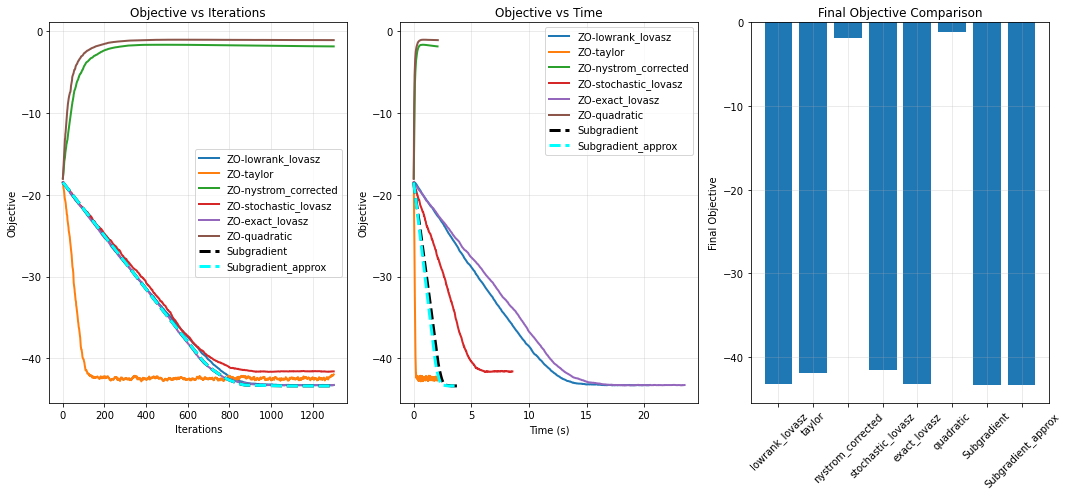


SUMMARY
lowrank_lovasz      : -43.2474 (time:  20.47s)
taylor              : -41.9470 (time:   2.17s)
nystrom_corrected   :  -1.8566 (time:   2.07s)
stochastic_lovasz   : -41.5793 (time:   8.57s)
exact_lovasz        : -43.2449 (time:  23.51s)
quadratic           :  -1.0885 (time:   2.09s)
Subgradient         : -43.3499 (time:   3.94s)
Subgradient_approx  : -43.3499 (time:   3.64s)

Best ZO method: lowrank_lovasz (-43.2474)
Subgradient: -43.3499
Improvement: -0.1025 (lower is better)


In [341]:
import numpy as np
import time
import matplotlib.pyplot as plt
from numpy.linalg import slogdet, inv, cholesky

# ----------------------------
# Submodular function: logdet with regularization
# ----------------------------
def submodular_logdet(S, K, delta=1.0, alpha=1.0):
    """F(S) = log det(δI + K[S,S]) - α|S|"""
    if len(S) == 0:
        return 0.0
    Ksub = K[np.ix_(S, S)]
    sign, logdet_val = slogdet(delta * np.eye(len(S)) + Ksub)
    return float(logdet_val) - alpha * len(S)

# ----------------------------
# Better Cheap Approximations for ZO
# ----------------------------

def low_rank_lovasz(w, K_lowrank, delta=1.0, alpha=1.0):
    """Cheap Lovász extension using low-rank kernel"""
    n = len(w)
    perm = np.argsort(-w)
    w_sorted = w[perm]
    w_next = np.concatenate([w_sorted[1:], [0.0]])
    diffs = w_sorted - w_next
    
    total = 0.0
    
    for i in range(n):
        Si = perm[:i+1]
        if len(Si) == 0:
            val = 0.0
        else:
            Ksub = K_lowrank[np.ix_(Si, Si)]
            try:
                L = cholesky(delta * np.eye(len(Si)) + Ksub)
                logdet_val = 2 * np.sum(np.log(np.diag(L)))
            except:
                sign, logdet_val = slogdet(delta * np.eye(len(Si)) + Ksub)
            val = float(logdet_val) - alpha * len(Si)
        total += diffs[i] * val
    return total

def taylor_surrogate(w, K, delta=1.0, alpha=1.0, order=2):
    """Taylor expansion surrogate"""
    n = len(w)
    
    # For Lovász extension, we need to think about f(A) = logdet(δI + K_AA)
    # The Taylor expansion should be around the EMPTY set, not around w=0
    
    if order == 1:
        # First order: f(A) ≈ (1/δ)·sum_{i∈A} K_ii
        surrogate = (1/delta) * np.sum(w * np.diag(K))
    elif order == 2:
        # Second order: f(A) ≈ (1/δ)·sum_{i∈A} K_ii - (1/(2δ²))·sum_{i,j∈A} K_ij²
        linear_term = (1/delta) * np.sum(w * np.diag(K))
        
        # Quadratic term: sum_{i,j} w_i w_j K_ij²
        K_squared = K * K  # Element-wise square
        quadratic_term = (1/(2*delta**2)) * (w @ K_squared @ w)
        
        surrogate = linear_term - quadratic_term
    else:
        # Higher orders would need more careful handling
        linear_term = (1/delta) * np.sum(w * np.diag(K))
        K_squared = K * K
        quadratic_term = (1/(2*delta**2)) * (w @ K_squared @ w)
        surrogate = linear_term - quadratic_term
    
    return surrogate - alpha * np.sum(w)
    
    # Add regularization
    return surrogate - alpha * np.sum(w)

def nystrom_corrected_surrogate(w, K_nys, K_full_diag, delta=1.0, alpha=1.0, correction_weight=0.3):
    """Balanced surrogate using diagonal correction"""
    quadratic = w @ (K_nys @ w)
    diagonal = w @ (K_full_diag * w)
    surrogate = (1 - correction_weight) * quadratic + correction_weight * diagonal
    return surrogate - alpha * np.sum(w)

def stochastic_lovasz(w, K, delta=1.0, alpha=1.0, sample_ratio=0.3):
    """Randomly sample prefixes for Lovász extension"""
    n = len(w)
    perm = np.random.permutation(n)
    w_perm = w[perm]
    sort_idx = np.argsort(-w_perm)
    perm_sorted = perm[sort_idx]
    w_sorted = w_perm[sort_idx]
    
    w_next = np.concatenate([w_sorted[1:], [0.0]])
    diffs = w_sorted - w_next
    
    total = 0.0
    sample_points = np.linspace(0, n-1, int(n * sample_ratio), dtype=int)
    
    prev_val = 0.0
    last_idx = 0
    for idx in sample_points:
        Si = perm_sorted[:idx+1]
        if len(Si) > 0:
            Ksub = K[np.ix_(Si, Si)]
            sign, logdet_val = slogdet(delta * np.eye(len(Si)) + Ksub)
            val = float(logdet_val) - alpha * len(Si)
            total += np.sum(diffs[last_idx:idx+1]) * val
            prev_val = val
            last_idx = idx + 1
    
    return total

# ----------------------------
# Exact Lovász extension
# ----------------------------
def exact_lovasz(w, K, delta=1.0, alpha=1.0):
    """Exact Lovász extension"""
    n = len(w)
    perm = np.argsort(-w)
    w_sorted = w[perm]
    w_next = np.concatenate([w_sorted[1:], [0.0]])
    diffs = w_sorted - w_next
    total = 0.0
    
    for i in range(n):
        Si = perm[: i+1]
        val = submodular_logdet(list(Si), K, delta, alpha)
        total += diffs[i] * val
    return float(total)

# ----------------------------
# Subgradient oracles
# ----------------------------
def lovasz_subgradient(w, K, delta=1.0, alpha=1.0):
    """Exact subgradient"""
    n = len(w)
    perm = np.argsort(-w)
    g = np.zeros(n, dtype=float)
    prev_val = 0.0
    
    for k in range(1, n+1):
        Sk = perm[:k]
        val = submodular_logdet(list(Sk), K, delta, alpha)
        marginal = val - prev_val
        g[perm[k-1]] = marginal
        prev_val = val
    return g

def lovasz_subgradient_approx(w, K_approx, delta=1.0, alpha=1.0):
    """Approximate subgradient using low-rank kernel"""
    n = len(w)
    perm = np.argsort(-w)
    g = np.zeros(n)
    prev_val = 0.0
    
    for k in range(1, n+1):
        Sk = perm[:k]
        # Use low-rank kernel for subgradient computation
        Ksub = K_approx[np.ix_(Sk, Sk)]
        sign, logdet_val = slogdet(delta * np.eye(len(Sk)) + Ksub)
        val = float(logdet_val) - alpha * len(Sk)
        marginal = val - prev_val
        g[perm[k-1]] = marginal
        prev_val = val
    return g

# ----------------------------
# Improved ZO Optimizers
# ----------------------------

def ZO_optimizer(w0, K_approx, K_full, delta=1.0, alpha=1.0, steps=1000, 
                mu=1e-3, base_alpha=0.01, m_samples=15, method='lowrank_lovasz'):
    """
    ZO optimizer with better approximations
    """
    n = len(w0)
    w = w0.copy()
    traj_obj = []
    times = []
    start = time.time()
    
    # Precompute for efficient surrogates
    K_diag = np.diag(K_full)
    
    for t in range(1, steps + 1):
        g_sum = np.zeros_like(w)
        
        # Choose surrogate function
        if method == 'lowrank_lovasz':
            f_w = low_rank_lovasz(w, K_approx, delta, alpha)
        elif method == 'taylor':
            f_w = taylor_surrogate(w, K_full, delta, alpha, order=2)
        elif method == 'nystrom_corrected':
            f_w = nystrom_corrected_surrogate(w, K_full, K_diag, delta, alpha)
        elif method == 'stochastic_lovasz':
            f_w = stochastic_lovasz(w, K_full, delta, alpha)
        elif method == 'exact_lovasz':  # ADDED EXACT LOVASZ METHOD
            f_w = exact_lovasz(w, K_full, delta, alpha)
        else:  # Original quadratic
            f_w = w @ (K_full @ w) - alpha * np.sum(w)
        
        
        for i in range(m_samples):
            u = np.random.normal(0, 1, n)
            
            
            w_perturbed = w + mu * u
            
            if method == 'lowrank_lovasz':
                f_plus = low_rank_lovasz(w_perturbed, K_approx, delta, alpha)
            elif method == 'taylor':
                f_plus = taylor_surrogate(w_perturbed, K_full, delta, alpha, order=2)
            elif method == 'nystrom_corrected':
                f_plus = nystrom_corrected_surrogate(w_perturbed, K_full, K_diag, delta, alpha)
            elif method == 'stochastic_lovasz':
                f_plus = stochastic_lovasz(w_perturbed, K_full, delta, alpha)
            elif method == 'exact_lovasz':  # ADDED EXACT LOVASZ METHOD
                f_plus = exact_lovasz(w_perturbed, K_full, delta, alpha)
            else:
                f_plus = w_perturbed @ (K_full @ w_perturbed) - alpha * np.sum(w_perturbed)
            
            gg = (f_plus - f_w) / mu * u
            g_sum += gg
        
        g_est = g_sum / m_samples
        
        w = w - base_alpha * g_est
        w = np.clip(w, 0.0, 1.0)
        
        # Record progress
        if t % 1 == 0 or t <= 20:
            exact_obj = exact_lovasz(w, K_full, delta, alpha)
            traj_obj.append(exact_obj)
            times.append(time.time() - start)
    
    return w, traj_obj, times

# ----------------------------
# Subgradient Method
# ----------------------------

def subgradient_method(w0, K, delta=1.0, alpha=1.0, steps=200, base_alpha=0.01):
    """Improved subgradient method"""
    n = len(w0)
    w = w0.copy()
    traj_obj = []
    times = []
    start = time.time()
    
    for t in range(1, steps + 1):
        # Use approximate subgradient for speed
        g = lovasz_subgradient(w, K, delta, alpha)
        
        w = w - base_alpha * g
        w = np.clip(w, 0.0, 1.0)
        
        # Record progress
        if t % 1 == 0 or t <= 20:
            exact_obj = exact_lovasz(w, K, delta, alpha)
            traj_obj.append(exact_obj)
            times.append(time.time() - start)
    
    return w, traj_obj, times

def subgradient_method_approx(w0, K, K_approx, delta=1.0, alpha=1.0, steps=200, base_alpha=0.01):
    """Improved subgradient method"""
    n = len(w0)
    w = w0.copy()
    traj_obj = []
    times = []
    start = time.time()
    
    for t in range(1, steps + 1):
        # Use approximate subgradient for speed
        g = lovasz_subgradient_approx(w, K_approx, delta, alpha)
        
        w = w - base_alpha * g
        w = np.clip(w, 0.0, 1.0)
        
        # Record progress
        if t % 1 == 0 or t <= 20:
            exact_obj = exact_lovasz(w, K, delta, alpha)
            traj_obj.append(exact_obj)
            times.append(time.time() - start)
    
    return w, traj_obj, times

# ----------------------------
# Experiment Setup
# ----------------------------

# Parameters
n = 60
delta = 1
alpha = 1.0  # Regularization strength
steps = 1300

# Generate data
X = np.linspace(0, 1, n)[:, None]
K_full = np.exp(-0.5 * ((X - X.T) ** 2) / 0.1 ** 2)

# Low-rank approximation
r = 30
idx = np.random.choice(n, r, replace=False)
K_rr = K_full[np.ix_(idx, idx)]
K_nr = K_full[:, idx]
K_approx = K_nr @ inv(K_rr + 1e-8 * np.eye(r)) @ K_nr.T

# Initial point
w0 = np.random.rand(n) * 0.5 + 0.2  # Start away from boundaries

# ----------------------------
# Run Comparisons
# ----------------------------

methods = [
    'lowrank_lovasz',
    'taylor', 
    'nystrom_corrected',
    'stochastic_lovasz',
    'exact_lovasz',  # ADDED EXACT LOVASZ METHOD
    'quadratic'  
]

results = {}

print("Running ZO methods comparison...")
for method in methods:
    print(f"Running ZO with {method}...")
    t0 = time.time()
    w_zo, traj_zo, times_zo = ZO_optimizer(
        w0, K_approx, K_full, delta, alpha, 
        steps=steps, mu=1e-3, base_alpha=0.001, m_samples=10, method=method
    )
    t_elapsed = time.time() - t0
    results[method] = (traj_zo, times_zo, t_elapsed)
    print(f"  {method}: {t_elapsed:.2f}s, final obj: {traj_zo[-1]:.4f}")

print("\nRunning subgradient method...")
t0 = time.time()
w_sg, traj_sg, times_sg = subgradient_method(
    w0, K_full, delta, alpha, steps=steps, base_alpha=0.001
)
t_sg = time.time() - t0
print(f"Subgradient: {t_sg:.2f}s, final obj: {traj_sg[-1]:.4f}")
t0 = time.time()
w_sga, traj_sga, times_sga = subgradient_method_approx(
    w0, K_full,K_approx, delta, alpha, steps=steps, base_alpha=0.001
)
t_sga = time.time() - t0
print(f"Subgradient_approx: {t_sga:.2f}s, final obj: {traj_sga[-1]:.4f}")
# ----------------------------
# Plot Results
# ----------------------------

plt.figure(figsize=(15, 7))

# Plot by iterations
plt.subplot(1, 3, 1)
for method in methods:
    traj_zo, times_zo, _ = results[method]
    iterations = np.arange(1, len(traj_zo) + 1) * (steps // len(traj_zo))
    plt.plot(iterations, traj_zo, label=f'ZO-{method}', linewidth=2)

sg_iterations = np.arange(1, len(traj_sg) + 1) * (steps // len(traj_sg))
plt.plot(sg_iterations, traj_sg, label='Subgradient', linewidth=3, color='black', linestyle='--')
sga_iterations = np.arange(1, len(traj_sga) + 1) * (steps // len(traj_sga))
plt.plot(sga_iterations, traj_sga, label='Subgradient_approx', linewidth=3, color='cyan', linestyle='--')
plt.xlabel('Iterations')
plt.ylabel('Objective')
plt.legend()
plt.title('Objective vs Iterations')
plt.grid(True, alpha=0.3)

# Plot by time
plt.subplot(1, 3, 2)
for method in methods:
    traj_zo, times_zo, _ = results[method]
    plt.plot(times_zo, traj_zo, label=f'ZO-{method}', linewidth=2)

plt.plot(times_sg, traj_sg, label='Subgradient', linewidth=3, color='black', linestyle='--')
plt.plot(times_sga, traj_sga, label='Subgradient_approx', linewidth=3, color='cyan', linestyle='--')
plt.xlabel('Time (s)')
plt.ylabel('Objective')
plt.legend()
plt.title('Objective vs Time')
plt.grid(True, alpha=0.3)

# Final objective comparison
plt.subplot(1, 3, 3)
final_objectives = [results[method][0][-1] for method in methods]
final_objectives.append(traj_sg[-1])
final_objectives.append(traj_sga[-1])
methods_with_sg = methods + ['Subgradient'] + ['Subgradient_approx']

plt.bar(range(len(methods_with_sg)), final_objectives)
plt.xticks(range(len(methods_with_sg)), methods_with_sg, rotation=45)
plt.ylabel('Final Objective')
plt.title('Final Objective Comparison')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ----------------------------
# Print Summary
# ----------------------------

print("\n" + "="*50)
print("SUMMARY")
print("="*50)
for method in methods:
    traj_zo, times_zo, t_elapsed = results[method]
    print(f"{method:20s}: {traj_zo[-1]:8.4f} (time: {t_elapsed:6.2f}s)")

print(f"{'Subgradient':20s}: {traj_sg[-1]:8.4f} (time: {t_sg:6.2f}s)")
print(f"{'Subgradient_approx':20s}: {traj_sga[-1]:8.4f} (time: {t_sga:6.2f}s)")
# Find best method
best_zo_method = min(methods, key=lambda m: results[m][0][-1])
best_zo_obj = results[best_zo_method][0][-1]

print(f"\nBest ZO method: {best_zo_method} ({best_zo_obj:.4f})")
print(f"Subgradient: {traj_sg[-1]:.4f}")

print(f"Improvement: {traj_sg[-1] - best_zo_obj:.4f} (lower is better)")

In [10]:
import numpy as np
import time
import matplotlib.pyplot as plt
from numpy.linalg import slogdet, inv, cholesky

# ----------------------------
# Submodular function: logdet(K_AA) with regularization
# ----------------------------
def submodular_logdet_k(S, K, alpha=1.0):
    """F(S) = log det(K[S,S]) - α|S|"""
    if len(S) == 0:
        return 0.0
    Ksub = K[np.ix_(S, S)]
    
    # Add tiny regularization for numerical stability
    reg = 1e-12 * np.eye(len(S))
    sign, logdet_val = slogdet(Ksub + reg)
    
    # If matrix is not positive definite, return large penalty
    # if sign <= 0:
    #     return -1e8
    
    return float(logdet_val) - alpha * len(S)

# ----------------------------
# Better Cheap Approximations for ZO for logdet(K_AA)
# ----------------------------

def low_rank_lovasz_k(w, K_lowrank, alpha=1.0):
    """Cheap Lovász extension using low-rank kernel for logdet(K)"""
    n = len(w)
    perm = np.argsort(-w)
    w_sorted = w[perm]
    w_next = np.concatenate([w_sorted[1:], [0.0]])
    diffs = w_sorted - w_next
    
    total = 0.0
    
    for i in range(n):
        Si = perm[:i+1]
        if len(Si) == 0:
            val = 0.0
        else:
            Ksub = K_lowrank[np.ix_(Si, Si)]
            # Add regularization for numerical stability
            reg = 1e-12 * np.eye(len(Si))
            try:
                L = cholesky(Ksub + reg)
                logdet_val = 2 * np.sum(np.log(np.diag(L)))
            except:
                sign, logdet_val = slogdet(Ksub + reg)
                if sign <= 0:
                    logdet_val = -1e6  # Penalty for non-PD matrix
            val = float(logdet_val) - alpha * len(Si)
        total += diffs[i] * val
    return total

def taylor_surrogate_k(w, K, alpha=1.0, order=2):
    """Corrected Taylor surrogate that properly uses K_w"""
    n = len(w)
    
    # Build weighted kernel matrix that depends on w
    W_sqrt = np.sqrt(np.clip(w, 1e-10, 1.0))
    K_w = W_sqrt[:, None] * K * W_sqrt[None, :]
    KI = K_w-np.eye(n)  
    trace1 = np.trace(KI)
    K_w2 = (KI) @ (KI)
    trace2 = np.trace(K_w2)
    surrogate = trace1 - 0.5 * trace2
    
    return surrogate - alpha * np.sum(w)

def eigenvalue_surrogate_k(w, K, alpha=1.0):
    """Eigenvalue-based surrogate for logdet(K_AA)"""
    n = len(w)
    
    # Build weighted kernel matrix that depends on w
    W_sqrt = np.sqrt(np.clip(w, 1e-8, 1.0))
    K_w = W_sqrt[:, None] * K * W_sqrt[None, :]
    
    # Get eigenvalues of K_w
    eigvals = np.linalg.eigvalsh(K_w)
    eigvals = np.clip(eigvals, 1e-12, None)  # Avoid log(0)
    
    # Sum of logs of eigenvalues = logdet
    logdet_approx = np.sum(np.log(eigvals))
    
    return logdet_approx - alpha * np.sum(w)


def stochastic_lovasz_k(w, K, alpha=1.0, sample_ratio=0.5):
    """Randomly sample prefixes for Lovász extension for logdet(K)"""
    n = len(w)
    perm = np.random.permutation(n)
    w_perm = w[perm]
    sort_idx = np.argsort(-w_perm)
    perm_sorted = perm[sort_idx]
    w_sorted = w_perm[sort_idx]
    
    w_next = np.concatenate([w_sorted[1:], [0.0]])
    diffs = w_sorted - w_next
    
    total = 0.0
    sample_points = np.linspace(0, n-1, int(n * sample_ratio), dtype=int)
    
    prev_val = 0.0
    last_idx = 0
    for idx in sample_points:
        Si = perm_sorted[:idx+1]
        if len(Si) > 0:
            Ksub = K[np.ix_(Si, Si)]
            # Add regularization for numerical stability
            reg = 1e-12 * np.eye(len(Si))
            sign, logdet_val = slogdet(Ksub + reg)
            if sign <= 0:
                val = -1e6  # Penalty for non-PD matrix
            else:
                val = float(logdet_val) - alpha * len(Si)
            total += np.sum(diffs[last_idx:idx+1]) * val
            prev_val = val
            last_idx = idx + 1
    
    return total

# ----------------------------
# Exact Lovász extension for logdet(K_AA)
# ----------------------------
def exact_lovasz_k(w, K, alpha=1.0):
    """Exact Lovász extension for logdet(K_AA)"""
    n = len(w)
    perm = np.argsort(-w)
    w_sorted = w[perm]
    w_next = np.concatenate([w_sorted[1:], [0.0]])
    diffs = w_sorted - w_next
    total = 0.0
    
    for i in range(n):
        Si = perm[: i+1]
        val = submodular_logdet_k(list(Si), K, alpha)
        total += diffs[i] * val
    return float(total)

# ----------------------------
# Subgradient oracles for logdet(K_AA)
# ----------------------------
def lovasz_subgradient_k(w, K, alpha=1.0):
    """Exact subgradient for logdet(K)"""
    n = len(w)
    perm = np.argsort(-w)
    g = np.zeros(n, dtype=float)
    prev_val = 0.0
    
    for k in range(1, n+1):
        Sk = perm[:k]
        val = submodular_logdet_k(list(Sk), K, alpha)
        marginal = val - prev_val
        g[perm[k-1]] = marginal
        prev_val = val
    return g

def lovasz_subgradient_approx_k(w, K_approx, alpha=1.0):
    """Approximate subgradient using low-rank kernel for logdet(K)"""
    n = len(w)
    perm = np.argsort(-w)
    g = np.zeros(n)
    prev_val = 0.0
    
    for k in range(1, n+1):
        Sk = perm[:k]
        # Use low-rank kernel for subgradient computation
        Ksub = K_approx[np.ix_(Sk, Sk)]
        # Add regularization for numerical stability
        reg = 1e-12 * np.eye(len(Sk))
        sign, logdet_val = slogdet(Ksub + reg)
        if sign <= 0:
            val = -1e6  # Penalty for non-PD matrix
        else:
            val = float(logdet_val) - alpha * len(Sk)
        marginal = val - prev_val
        g[perm[k-1]] = marginal
        prev_val = val
    return g

# ----------------------------
# Improved ZO Optimizers for logdet(K_AA)
# ----------------------------

def ZO_optimizer_k(w0, K_approx, K_full, alpha=1.0, steps=1000, 
                mu=1e-3, base_alpha=0.01, m_samples=15, method='lowrank_lovasz_k'):
    """
    ZO optimizer with better approximations for logdet(K_AA)
    """
    n = len(w0)
    w = w0.copy()
    traj_obj = []
    times = []
    start = time.time()
    
    # Precompute for efficient surrogates
    K_diag = np.diag(K_full)
    
    for t in range(1, steps + 1):
        g_sum = np.zeros_like(w)
        
        # Choose surrogate function
        if method == 'ZO_GD (Low-rank)':
            f_w = low_rank_lovasz_k(w, K_approx, alpha)
        elif method == 'ZO-GD (Taylor)':
            f_w = taylor_surrogate_k(w, K_full, alpha, order=2)
        elif method == 'eigenvalue_k':  # ADDED EIGENVALUE METHOD
            f_w = eigenvalue_surrogate_k(w, K_full, alpha)
        elif method == 'ZO-GD (Stochastic)':
            f_w = stochastic_lovasz_k(w, K_full, alpha)
        elif method == 'ZO-GD (Exact)':
            f_w = exact_lovasz_k(w, K_full, alpha)
        else:  # Original quadratic
            f_w = w @ (K_full @ w) - alpha * np.sum(w)
        
        
        for i in range(m_samples):
            u = np.random.normal(0, 1, n)
            
            
            w_perturbed = w + mu * u
            
            if method == 'ZO_GD (Low-rank)':
                f_plus = low_rank_lovasz_k(w_perturbed, K_approx, alpha)
            elif method == 'ZO-GD (Taylor)':
                f_plus = taylor_surrogate_k(w_perturbed, K_full, alpha, order=2)
            elif method == 'eigenvalue_k':  # ADDED EIGENVALUE METHOD
                f_plus = eigenvalue_surrogate_k(w_perturbed, K_full, alpha)
            elif method == 'ZO-GD (Stochastic)':
                f_plus = stochastic_lovasz_k(w_perturbed, K_full, alpha)
            elif method == 'ZO-GD (Exact)':
                f_plus = exact_lovasz_k(w_perturbed, K_full, alpha)
            else:
                f_plus = w_perturbed @ (K_full @ w_perturbed) - alpha * np.sum(w_perturbed)
            
            gg = (f_plus - f_w) / mu * u
            g_sum += gg
        
        g_est = g_sum / m_samples
        
        w = w - base_alpha * g_est
        w = np.clip(w, 0.0, 1.0)
        
        # Record progress
        if t % 1 == 0 or t <= 20:
            exact_obj = exact_lovasz_k(w, K_full, alpha)
            traj_obj.append(exact_obj)
            times.append(time.time() - start)
    
    return w, traj_obj, times

# ----------------------------
# Subgradient Method for logdet(K_AA)
# ----------------------------

def subgradient_method_k(w0, K, alpha=1.0, steps=200, base_alpha=0.01):
    n = len(w0)
    w = w0.copy()
    traj_obj = []
    times = []
    start = time.time()
    
    for t in range(1, steps + 1):
        # Use approximate subgradient for speed
        g = lovasz_subgradient_k(w, K, alpha)
        
        w = w - base_alpha * g
        w = np.clip(w, 0.0, 1.0)
        
        # Record progress
        if t % 1 == 0 or t <= 20:
            exact_obj = exact_lovasz_k(w, K, alpha)
            traj_obj.append(exact_obj)
            times.append(time.time() - start)
    
    return w, traj_obj, times

def subgradient_method_approx_k(w0, K, K_approx, alpha=1.0, steps=200, base_alpha=0.01):
    """Improved subgradient method for logdet(K)"""
    n = len(w0)
    w = w0.copy()
    traj_obj = []
    times = []
    start = time.time()
    
    for t in range(1, steps + 1):
        # Use approximate subgradient for speed
        g = lovasz_subgradient_approx_k(w, K_approx, alpha)
        
        w = w - base_alpha * g
        w = np.clip(w, 0.0, 1.0)
        
        # Record progress
        if t % 1 == 0 or t <= 20:
            exact_obj = exact_lovasz_k(w, K, alpha)
            traj_obj.append(exact_obj)
            times.append(time.time() - start)
    
    return w, traj_obj, times

# ----------------------------
# Experiment Setup for logdet(K_AA)
# ----------------------------

# Parameters
n = 50
alpha = 0  # Different regularization might be needed for logdet(K)

# Generate well-conditioned kernel matrix
X = np.random.uniform(0, 1, size=(n, 1))
# X = np.linspace(0, 1, n)[:, None]
K_full = np.exp(-0.5 * ((X - X.T) ** 2) / 0.1 ** 2)

# Ensure K_full is well-conditioned by adding small diagonal
K_full += 0.01 * np.eye(n)

# Low-rank approximation
r = 25
idx = np.random.choice(n, r, replace=False)
K_rr = K_full[np.ix_(idx, idx)]
K_nr = K_full[:, idx]
K_approx = K_nr @ inv(K_rr + 1e-8 * np.eye(r)) @ K_nr.T

# Ensure K_approx is positive definite
K_approx = 0.5 * (K_approx + K_approx.T) + 0.01 * np.eye(n)

# Initial point - start with larger values to avoid empty set issues
# w0=np.linspace(0,1,n)
# w0 = np.random.rand(n) * 0.5 + 0.3
w0=np.random.uniform(0, 1,n)


Running ZO methods comparison for logdet(K_AA)...
Running ZO with ZO_GD (Low-rank)...
  ZO_GD (Low-rank): 61.91s, final obj: -171.5371
Running ZO with ZO-GD (Taylor)...
  ZO-GD (Taylor): 3.76s, final obj: -171.0444
Running ZO with ZO-GD (Stochastic)...
  ZO-GD (Stochastic): 38.60s, final obj: -163.6915
Running ZO with ZO-GD (Exact)...
  ZO-GD (Exact): 73.82s, final obj: -171.5175

Running subgradient method for logdet(K_AA)...
Subgradient (Exact): 3.95s, final obj: -171.6692
Subgradient (Low-rank): 3.68s, final obj: -171.6692


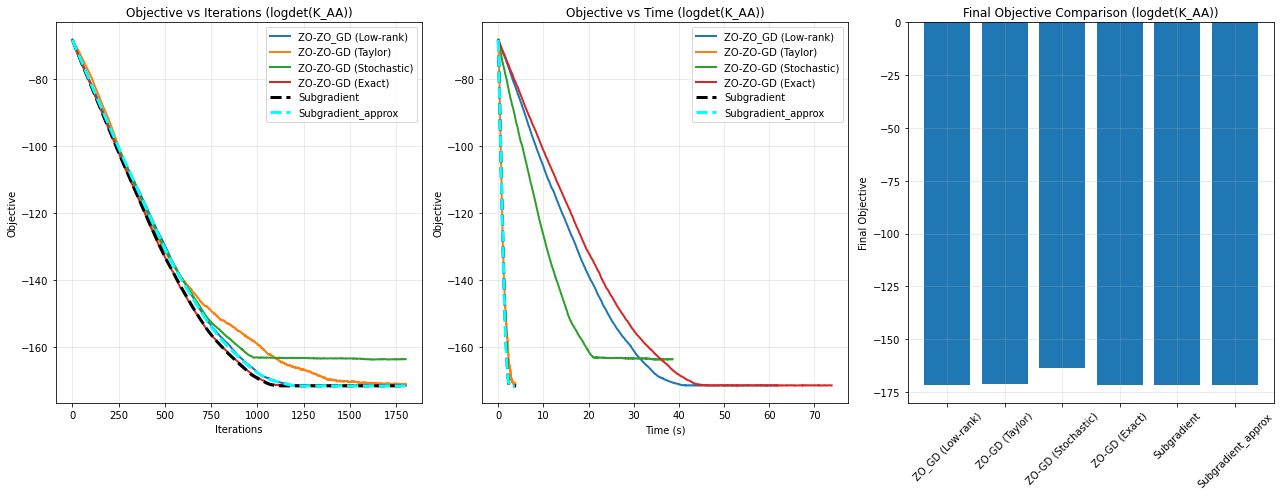


SUMMARY FOR LOGDET(K_AA)
ZO_GD (Low-rank)         : -171.5371 (time:  61.91s)
ZO-GD (Taylor)           : -171.0444 (time:   3.76s)
ZO-GD (Stochastic)       : -163.6915 (time:  38.60s)
ZO-GD (Exact)            : -171.5175 (time:  73.82s)
Subgradient              : -171.6692 (time:   3.95s)
Subgradient_approx       : -171.6692 (time:   3.68s)

Best ZO method: ZO_GD (Low-rank) (-171.5371)
Subgradient: -171.6692
Improvement: -0.1321 (lower is better)


In [11]:
# ----------------------------
# Run Comparisons for logdet(K_AA)
# ----------------------------
steps = 1800
h=0.0002
methods_k = [
    'ZO_GD (Low-rank)',
    'ZO-GD (Taylor)', 
    'ZO-GD (Stochastic)',
    'ZO-GD (Exact)', 
]

results_k = {}

print("Running ZO methods comparison for logdet(K_AA)...")
for method in methods_k:
    print(f"Running ZO with {method}...")
    t0 = time.time()
    w_zo, traj_zo, times_zo = ZO_optimizer_k(
        w0, K_approx, K_full, alpha, 
        steps=steps, mu=1e-3, base_alpha=h, m_samples=35, method=method
    )
    t_elapsed = time.time() - t0
    results_k[method] = (traj_zo, times_zo, t_elapsed)
    print(f"  {method}: {t_elapsed:.2f}s, final obj: {traj_zo[-1]:.4f}")

print("\nRunning subgradient method for logdet(K_AA)...")
t0 = time.time()
w_sg, traj_sg, times_sg = subgradient_method_k(
    w0, K_full, alpha, steps=steps, base_alpha=h
)
t_sg = time.time() - t0
print(f"Subgradient (Exact): {t_sg:.2f}s, final obj: {traj_sg[-1]:.4f}")
t0 = time.time()
w_sga, traj_sga, times_sga = subgradient_method_approx_k(
    w0, K_full, K_approx, alpha, steps=steps, base_alpha=h
)
t_sga = time.time() - t0
print(f"Subgradient (Low-rank): {t_sga:.2f}s, final obj: {traj_sga[-1]:.4f}")

# ----------------------------
# Plot Results for logdet(K_AA)
# ----------------------------

plt.figure(figsize=(18, 7))

# Plot by iterations
plt.subplot(1, 3, 1)
for method in methods_k:
    traj_zo, times_zo, _ = results_k[method]
    iterations = np.arange(1, len(traj_zo) + 1) * (steps // len(traj_zo))
    plt.plot(iterations, traj_zo, label=f'ZO-{method}', linewidth=2)

sg_iterations = np.arange(1, len(traj_sg) + 1) * (steps // len(traj_sg))
plt.plot(sg_iterations, traj_sg, label='Subgradient', linewidth=3, color='black', linestyle='--')
sga_iterations = np.arange(1, len(traj_sga) + 1) * (steps // len(traj_sga))
plt.plot(sga_iterations, traj_sga, label='Subgradient_approx', linewidth=3, color='cyan', linestyle='--')
plt.xlabel('Iterations')
plt.ylabel('Objective')
plt.legend()
plt.title('Objective vs Iterations (logdet(K_AA))')
plt.grid(True, alpha=0.3)

# Plot by time
plt.subplot(1, 3, 2)
for method in methods_k:
    traj_zo, times_zo, _ = results_k[method]
    plt.plot(times_zo, traj_zo, label=f'ZO-{method}', linewidth=2)

plt.plot(times_sg, traj_sg, label='Subgradient', linewidth=3, color='black', linestyle='--')
plt.plot(times_sga, traj_sga, label='Subgradient_approx', linewidth=3, color='cyan', linestyle='--')
plt.xlabel('Time (s)')
plt.ylabel('Objective')
plt.legend()
plt.title('Objective vs Time (logdet(K_AA))')
plt.grid(True, alpha=0.3)

# Final objective comparison
plt.subplot(1, 3, 3)
final_objectives = [results_k[method][0][-1] for method in methods_k]
final_objectives.append(traj_sg[-1])
final_objectives.append(traj_sga[-1])
methods_with_sg = methods_k + ['Subgradient'] + ['Subgradient_approx']

plt.bar(range(len(methods_with_sg)), final_objectives)
plt.xticks(range(len(methods_with_sg)), methods_with_sg, rotation=45)
plt.ylabel('Final Objective')
plt.title('Final Objective Comparison (logdet(K_AA))')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ----------------------------
# Print Summary for logdet(K_AA)
# ----------------------------

print("\n" + "="*50)
print("SUMMARY FOR LOGDET(K_AA)")
print("="*50)
for method in methods_k:
    traj_zo, times_zo, t_elapsed = results_k[method]
    print(f"{method:25s}: {traj_zo[-1]:8.4f} (time: {t_elapsed:6.2f}s)")

print(f"{'Subgradient':25s}: {traj_sg[-1]:8.4f} (time: {t_sg:6.2f}s)")
print(f"{'Subgradient_approx':25s}: {traj_sga[-1]:8.4f} (time: {t_sga:6.2f}s)")

# Find best method
best_zo_method = min(methods_k, key=lambda m: results_k[m][0][-1])
best_zo_obj = results_k[best_zo_method][0][-1]

print(f"\nBest ZO method: {best_zo_method} ({best_zo_obj:.4f})")
print(f"Subgradient: {traj_sg[-1]:.4f}")
print(f"Improvement: {traj_sg[-1] - best_zo_obj:.4f} (lower is better)")

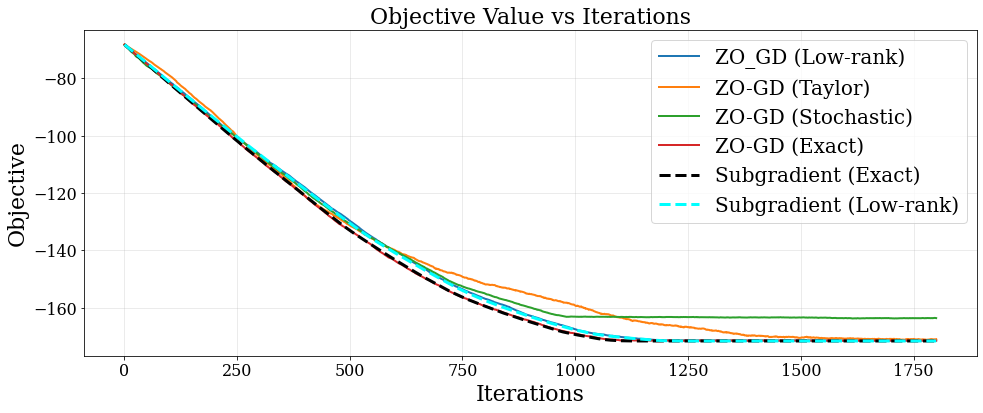

In [14]:
font = {'family': 'serif', 'color':  'black', 'weight': 'normal', 'size': 22}
font1 = {'family': 'serif', 'size': 20}
plt.figure(figsize=(16, 6))
plt.xticks(fontname='serif', fontsize=16, color='black')
plt.yticks(fontname='serif', fontsize=16, color='black')
for method in methods_k:
    traj_zo, times_zo, _ = results_k[method]
    iterations = np.arange(1, len(traj_zo) + 1) * (steps // len(traj_zo))
    plt.plot(iterations, traj_zo, label=f'{method}', linewidth=2)

sg_iterations = np.arange(1, len(traj_sg) + 1) * (steps // len(traj_sg))
plt.plot(sg_iterations, traj_sg, label='Subgradient (Exact)', linewidth=3, color='black', linestyle='--')
sga_iterations = np.arange(1, len(traj_sga) + 1) * (steps // len(traj_sga))
plt.plot(sga_iterations, traj_sga, label='Subgradient (Low-rank)', linewidth=3, color='cyan', linestyle='--')
plt.xlabel('Iterations',fontdict=font)
plt.ylabel('Objective',fontdict=font)
plt.legend(loc='best', prop=font1)
plt.title('Objective Value vs Iterations',fontdict=font)
plt.grid(True, alpha=0.3)
plt.savefig('iter.pdf', format='pdf',bbox_inches='tight')

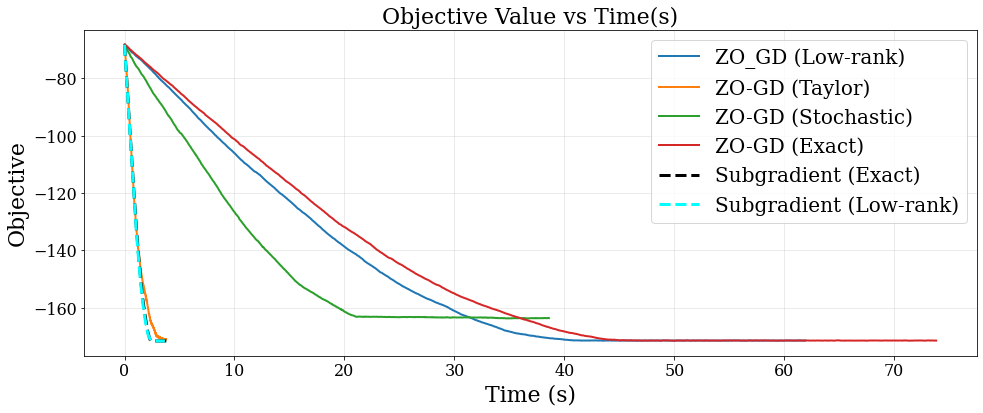

In [15]:
font = {'family': 'serif', 'color':  'black', 'weight': 'normal', 'size': 22}
font1 = {'family': 'serif', 'size': 20}
plt.figure(figsize=(16, 6))
plt.xticks(fontname='serif', fontsize=16, color='black')
plt.yticks(fontname='serif', fontsize=16, color='black')
for method in methods_k:
    traj_zo, times_zo, _ = results_k[method]
    plt.plot(times_zo, traj_zo, label=f'{method}', linewidth=2)

plt.plot(times_sg, traj_sg, label='Subgradient (Exact)', linewidth=3, color='black', linestyle='--')
plt.plot(times_sga, traj_sga, label='Subgradient (Low-rank)', linewidth=3, color='cyan', linestyle='--')
plt.xlabel('Time (s)',fontdict=font)
plt.ylabel('Objective',fontdict=font)
plt.legend(loc='best', prop=font1)
plt.title('Objective Value vs Time(s)',fontdict=font)
plt.grid(True, alpha=0.3)
plt.savefig('time.pdf', format='pdf',bbox_inches='tight')

Below the offline semi-supervised clustering problem is solved via minimisation of a submodular functions. The above solvers are used to solve this problem.

In [1]:
import numpy as np
import numpy.linalg as la
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt

# Data and kernel
X, true_labels = make_moons(n_samples=50, noise=0.04, random_state=7)
p = X.shape[0]
diff = X[:, np.newaxis, :] - X[np.newaxis, :, :]
dist_sq = np.sum(diff ** 2, axis=2)
K = np.exp(-dist_sq / (2 * 0.1))  # sigma^2 = 1

def mutual_information(A_bin, K):
    A_indices = np.where(A_bin == 1)[0]
    B_indices = np.where(A_bin == 0)[0]
    K_AA = K[np.ix_(A_indices, A_indices)] + 1e-8 * np.eye(len(A_indices))
    K_BB = K[np.ix_(B_indices, B_indices)] + 1e-8 * np.eye(len(B_indices))
    K_full = K + 1e-8 * np.eye(p)
    log_det_AA = la.slogdet(K_AA)[1]
    log_det_BB = la.slogdet(K_BB)[1]
    log_det_full = la.slogdet(K_full)[1]
    return  0.5*(log_det_AA + log_det_BB - log_det_full)

# Set up eta: unlabeled eta=0.5, labeled hard constraints
labeled_cluster0 = np.random.choice(np.where(true_labels == 0)[0], 4, replace=False)
labeled_cluster1 = np.random.choice(np.where(true_labels == 1)[0], 4, replace=False)
labeled_indices = np.concatenate([labeled_cluster0, labeled_cluster1])
eta = np.full(p, 0.5)
eta[labeled_cluster1] = 1.0
eta[labeled_cluster0] = 0.0

def submodular_cost(A_bin, K, eta):
    I = mutual_information(A_bin, K)
    prior_term = 0.0
    for k in range(p):
        if A_bin[k] == 1:
            prior_term -= np.log(eta[k] + 1e-10)
        else:
            prior_term -= np.log(1 - eta[k] + 1e-10)
    return I + prior_term

# Polyhedron greedy algorithm
def polyhedrongreedy(F, V, w):
    n = len(V)
    w_sorted, I = np.sort(w)[::-1], np.argsort(w)[::-1]
    x = np.zeros(n)
    A = np.array([], dtype=int)
    Fold = F(np.zeros(n, dtype=int))
    for i in range(n):
        Anew = np.concatenate((A, [V[I[i]]]))
        A_bin = np.zeros(n, dtype=int)
        A_bin[Anew] = 1
        x[I[i]] = F(A_bin) - Fold
        A = Anew
        Fold += x[I[i]]
    return x

# Lovász extension
def lovasz_extension(F, V, w):
    x = polyhedrongreedy(F, V, w)
    return np.dot(w, x)

# ===============================
# NEW: Taylor Surrogate for Mutual Information
# ===============================
def mutual_information_taylor_surrogate(w, K, eta):
    """Taylor surrogate for mutual information cost function"""
    n = len(w)
    # Build weighted kernel matrices for A and B
    W_sqrt_A = np.sqrt(np.clip(w, 1e-8, 1.0))
    W_sqrt_B = np.sqrt(np.clip(1 - w, 1e-8, 1.0))
    
    K_A = W_sqrt_A[:, None] * K * W_sqrt_A[None, :]
    K_B = W_sqrt_B[:, None] * K * W_sqrt_B[None, :]
    K_full_weighted = K  # Full kernel remains the same
    
    # Taylor approximation for each logdet term
    def logdet_taylor(K_mat):
        K_matt = K_mat-np.eye(n)
        trace1 = np.trace(K_matt)
        K_matt2 = K_matt @ K_matt
        trace2 = np.trace(K_matt2)
        return trace1 - 0.5 * trace2
    
    logdet_AA = logdet_taylor(K_A)
    logdet_BB = logdet_taylor(K_B)
    logdet_full = logdet_taylor(K_full_weighted)
    
    I_surrogate = 0.5 * (logdet_AA + logdet_BB - logdet_full)
    
    # Prior term (exact, since it's linear)
    prior_term = -np.sum(w * np.log(eta + 1e-10) + (1 - w) * np.log(1 - eta + 1e-10))
    
    return I_surrogate + prior_term

# ===============================
# NEW: Low-rank kernel approximation
# ===============================
def create_lowrank_kernel(K, rank=20):
    """Create low-rank approximation of kernel matrix using SVD"""
    U, s, Vt = np.linalg.svd(K, full_matrices=False)
    # Keep top rank components
    U_low = U[:, :rank]
    s_low = s[:rank]
    K_lowrank = U_low @ np.diag(s_low) @ U_low.T
    return K_lowrank

# ===============================
# NEW: Stochastic Lovász Extension
# ===============================
def stochastic_lovasz_extension(F, V, w, num_samples=10):
    """Stochastic approximation of Lovász extension"""
    n = len(V)
    total = 0.0
    
    for _ in range(num_samples):
        # Sample random permutation
        perm = np.random.permutation(n)
        w_perm = w[perm]
        
        # Sort this permutation by w values
        sort_idx = np.argsort(-w_perm)
        perm_sorted = perm[sort_idx]
        w_sorted = w_perm[sort_idx]
        
        w_next = np.concatenate([w_sorted[1:], [0.0]])
        diffs = w_sorted - w_next
        
        # Sample only a subset of prefixes
        sample_points = np.random.choice(n, size=max(1, n//3), replace=False)
        sample_points = np.sort(sample_points)
        
        prev_val = F(np.zeros(n, dtype=int))
        last_idx = 0
        
        for idx in sample_points:
            Si = perm_sorted[:idx+1]
            A_bin = np.zeros(n, dtype=int)
            A_bin[Si] = 1
            val = F(A_bin)
            total += np.sum(diffs[last_idx:idx+1]) * val
            prev_val = val
            last_idx = idx + 1
    
    return total / num_samples

def lovasz_subgradient(F, V, w):
    """
    Computes a subgradient of the Lovász extension of a submodular function F at point w.
    Args:
        F: Submodular set function, takes binary vector.
        V: Ground set indices (e.g., np.arange(p)).
        w: Point at which to compute subgradient (vector of size p).
    Returns:
        subgrad: Subgradient vector (size p).
    """
    n = len(V)
    w_sorted, I = np.sort(w)[::-1], np.argsort(w)[::-1]  # Sort in descending order
    subgrad = np.zeros(n)
    A = np.array([], dtype=int)
    Fold = F(np.zeros(n, dtype=int))  # Initial empty set
    for i in range(n):
        Anew = np.concatenate((A, [V[I[i]]]))
        A_bin = np.zeros(n, dtype=int)
        A_bin[Anew] = 1
        subgrad[I[i]] = F(A_bin) - Fold
        A = Anew
        Fold += subgrad[I[i]]
    return subgrad


# Example usage
V = np.arange(p)
w0 = np.random.rand(p)
w0[labeled_cluster0] = 0
w0[labeled_cluster1] = 1
F = lambda A_bin: submodular_cost(A_bin, K, eta)

# ===============================
# Create low-rank kernel and corresponding cost function
# ===============================
K_lowrank = create_lowrank_kernel(K, rank=30)
F_lowrank = lambda A_bin: submodular_cost(A_bin, K_lowrank, eta)

# ===============================
# Create Taylor surrogate function
# ===============================
FL_taylor = lambda w: mutual_information_taylor_surrogate(w, K, eta)

# ===============================
# Create stochastic Lovász function
# ===============================
FL_stochastic = lambda w: stochastic_lovasz_extension(F, V, w, num_samples=25)

# Original exact functions
FL = lambda w: lovasz_extension(F, V, w)
FL_subgrad = lambda w: lovasz_subgradient(F, V, w)

# ===============================
# Low-rank subgradient function
# ===============================
FL_lowrank = lambda w: lovasz_extension(F_lowrank, V, w)
FL_subgrad_lowrank = lambda w: lovasz_subgradient(F_lowrank, V, w)

def proj01(x, low=0, high=1):
    x = np.clip(x, low, high)
    return x

def grad(func, x, mu=0.05, Y=10):
    gs = []
    for _ in range(Y):
        u = np.random.normal(0, 1, size=len(x))
        g = (func(x + mu * u) - func(x)) / mu
        gs.append(g * u)
    g = np.mean(gs, axis=0)
    g[labeled_indices] = 0
    return g

def step(func, x, h, mu=0.05, Y=10):
    grd = grad(func, x, mu, Y)
    xx = x - h * grd
    return xx

def RM(func, x0, N, h=0.001, mu=0.05, proj=None, Y=10):
    dim1 = len(x0)
    x = np.zeros((dim1, N + 1))
    x[:, 0] = x0.ravel()
    times=[]
    start=time.time()
    for k in range(N):
        x[:, k + 1] = proj(step(func, x[:, k], h, mu, Y))
        times.append(time.time() - start)
    return x,times

def submin(subfunc, x0, N, h=0.001, proj=None):
    dim1 = len(x0)
    x = np.zeros((dim1, N + 1))
    x[:, 0] = x0.ravel()
    times=[]
    start=time.time()
    for k in range(N):
        x[:, k + 1] = proj(x[:, k] - h * subfunc(x[:, k]))
        times.append(time.time() - start)
    return x,times

def round_solution(w, F):
    order = np.argsort(-w)
    best_set = None
    best_val = float("inf")
    A_bin = np.zeros(len(w), dtype=int)
    for k in range(1, len(w)+1):
        A_bin[:] = 0
        A_bin[order[:k]] = 1
        val = F(A_bin)
        if val < best_val:
            best_val = val
            best_set = A_bin.copy()
    return best_set, best_val



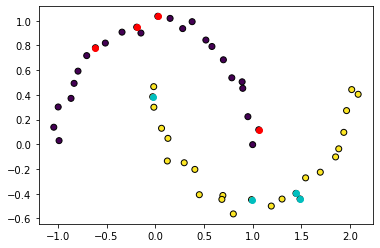

In [2]:
plt.scatter(X[:,0], X[:,1], c=true_labels, edgecolors="k")
plt.plot(X[labeled_cluster0,0],X[labeled_cluster0,1],'or')
plt.plot(X[labeled_cluster1,0],X[labeled_cluster1,1],'oc')

In [314]:
# ===============================
# NEW: Run all methods
# ===============================
N = 5000
mu = 1e-7
h = 4e-4
methods = {
    'ZO-GD (Exact)': FL,
    'ZO-GD (Low-Rank)': FL_lowrank,
    'ZO-GD (Taylor)': FL_taylor,
    'Subgradient (Exact)': FL_subgrad,
    'Subgradient (Low-rank)': FL_subgrad_lowrank
}

results = {}

print("Running all methods...")

# ZO-GD with Exact Lovász
print("Running ZO-RM (Exact)...")
ww_exact,time_ZOexact = RM(FL, w0, N, h=h, mu=mu, proj=proj01, Y=5)
FLs_exact = [FL(ww_exact[:, i]) for i in range(N)]
results['ZO-GD (Exact)'] = (ww_exact, FLs_exact,time_ZOexact)

# ZO-GD with Exact Lovász
print("Running ZO-RM (Low-rank)...")
ww_exact,time_ZOlow = RM(FL, w0, N, h=h, mu=mu, proj=proj01, Y=5)
FLs_exact = [FL(ww_exact[:, i]) for i in range(N)]
results['ZO-GD (Low-rank)'] = (ww_exact, FLs_exact,time_ZOlow)

# ZO-GD with Taylor
print("Running ZO-RM (Taylor)...")
ww_taylor,time_ZOtaylor = RM(FL_taylor, w0, N, h=h*5, mu=mu, proj=proj01, Y=30)
FLs_taylor = [FL(ww_taylor[:, i]) for i in range(N)]  # Evaluate with exact FL for comparison
results['ZO-GD (Taylor)'] = (ww_taylor, FLs_taylor,time_ZOtaylor)

# Subgradient with Exact
print("Running Subgradient (Exact)...")
ww_sub_exact,time_Sub = submin(FL_subgrad, w0, N, h=h, proj=proj01)
FLs_sub_exact = [FL(ww_sub_exact[:, i]) for i in range(N)]
results['Subgradient (Exact)'] = (ww_sub_exact, FLs_sub_exact,time_Sub)

# Subgradient with Low-rank
print("Running Subgradient (Low-rank)...")
ww_sub_lowrank,time_Sublow = submin(FL_subgrad_lowrank, w0, N, h=h, proj=proj01)
FLs_sub_lowrank = [FL(ww_sub_lowrank[:, i]) for i in range(N)]
results['Subgradient (Low-rank)'] = (ww_sub_lowrank, FLs_sub_lowrank,time_Sublow)




Running all methods...
Running ZO-RM (Exact)...
Running ZO-RM (Low-rank)...
Running ZO-RM (Taylor)...
Running Subgradient (Exact)...
Running Subgradient (Low-rank)...


In [317]:
# ===============================
# Print summary
# ===============================
print("\n" + "="*50)
print("METHODS COMPARISON SUMMARY")
print("="*50)

for method_name, (ww, FL_vals, times) in results.items():
    min_idx = np.argmin(FL_vals)
    min_val = FL_vals[min_idx]
    w_final = ww[:, min_idx]
    A_bin, F_val = round_solution(w_final, F)
    
    
    print(f"{method_name:25s}: Final FL = {min_val:8.4f}, Rounded Cost = {F_val:8.4f}, Time(s) = {times[-1]: 8.4f}"   )

# Compare with true labels
true_cost = F(true_labels)
print(f"{'True Labels':25s}: Cost = {true_cost:8.4f}")


METHODS COMPARISON SUMMARY
ZO-GD (Exact)            : Final FL = -86.2184, Rounded Cost =  31.1038, Time(s) =  252.8491
ZO-GD (Low-rank)         : Final FL = -85.0202, Rounded Cost =  31.1038, Time(s) =  252.7873
ZO-GD (Taylor)           : Final FL = -86.2136, Rounded Cost =  31.1038, Time(s) =  20.7759
Subgradient (Exact)      : Final FL = -90.0748, Rounded Cost =  31.1038, Time(s) =  25.1056
Subgradient (Low-rank)   : Final FL = -81.8771, Rounded Cost =  38.7669, Time(s) =  25.2872
True Labels              : Cost =  31.1038


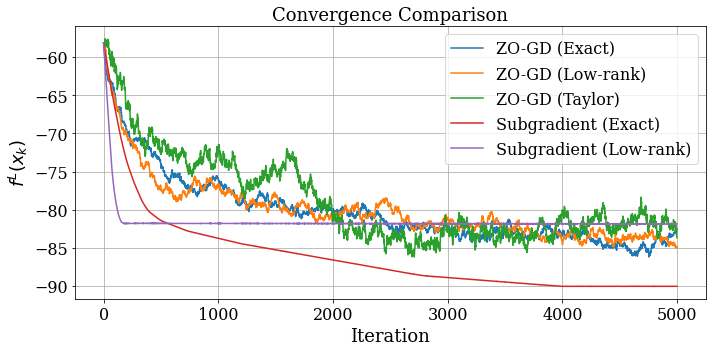

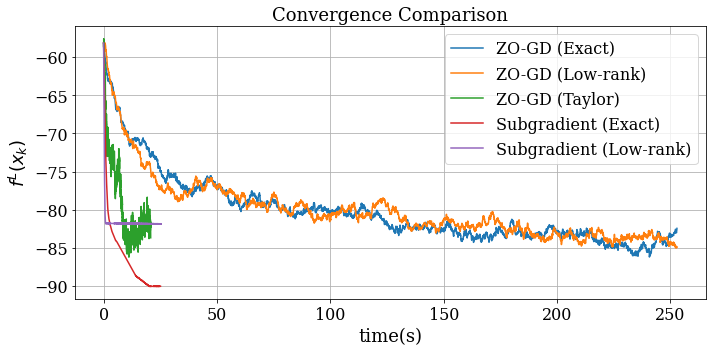

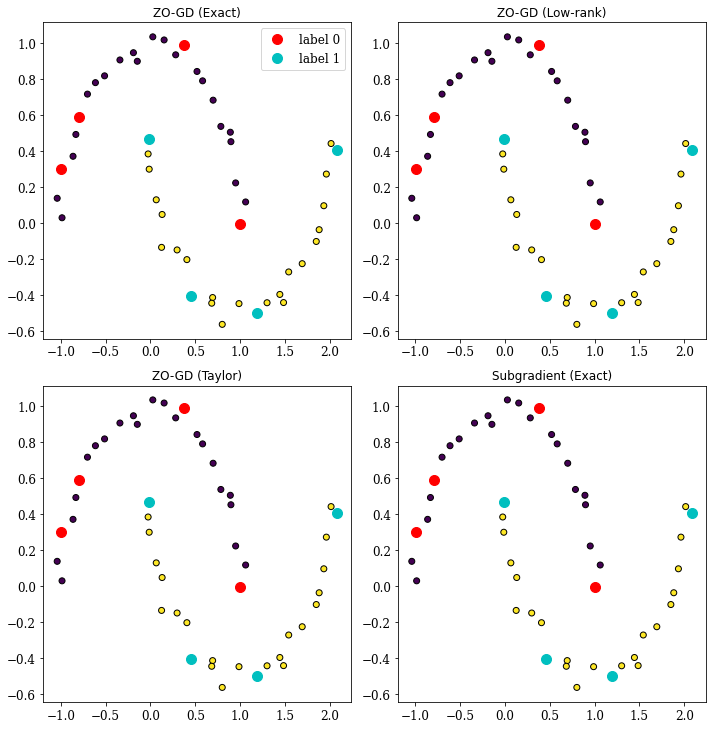

In [319]:
# ===============================
font = {'family': 'serif', 'color':  'black', 'weight': 'normal', 'size': 18}
font1 = {'family': 'serif', 'size': 16}
plt.figure(figsize=(10,5))
plt.xticks(fontname='serif', fontsize=16, color='black')
plt.yticks(fontname='serif', fontsize=16, color='black')
for method_name, (_, FL_vals,times) in results.items():
    plt.plot(FL_vals, label=method_name)
plt.title('Convergence Comparison',fontdict=font)
plt.xlabel('Iteration',fontdict=font)
plt.ylabel(r'$f^L(x_k)$',fontdict=font)
plt.grid(True)
plt.legend(loc='best', prop=font1)
plt.tight_layout()
plt.savefig('ffval.pdf', format='pdf',bbox_inches='tight')

plt.figure(figsize=(10,5))
plt.xticks(fontname='serif', fontsize=16, color='black')
plt.yticks(fontname='serif', fontsize=16, color='black')
for method_name, (_, FL_vals,times) in results.items():
    plt.plot(times,FL_vals, label=method_name)
plt.title('Convergence Comparison',fontdict=font)
plt.xlabel('time(s)',fontdict=font)
plt.ylabel(r'$f^L(x_k)$',fontdict=font)
plt.grid(True)
plt.legend(loc='best', prop=font1)
plt.tight_layout()
plt.savefig('ffval2.pdf', format='pdf',bbox_inches='tight')

font = {'family': 'serif', 'color':  'black', 'weight': 'normal', 'size': 16}
font1 = {'family': 'serif', 'size': 12}
plt.figure(figsize=(10, 15))
# Plot final clusterings
methods_to_plot = list(results.keys())
for i, method_name in enumerate(methods_to_plot[:-1]):
    ww, FL_vals,_ = results[method_name]
    min_idx = np.argmin(FL_vals)
    w_final = ww[:, min_idx]
    
    # Round solution
    A_bin, F_val = round_solution(w_final, F)
    
    plt.subplot(3, 2, i+1)
    plt.xticks(fontname='serif', fontsize=12, color='black')
    plt.yticks(fontname='serif', fontsize=12, color='black')
    plt.scatter(X[:, 0], X[:, 1], c=A_bin, edgecolors="k")
    plt.plot(X[labeled_cluster0, 0], X[labeled_cluster0, 1], 'or', markersize=10, label='label 0')
    plt.plot(X[labeled_cluster1, 0], X[labeled_cluster1, 1], 'oc', markersize=10, label='label 1')
    plt.title(f'{method_name}')
    if i == 0:
        plt.legend(loc='best', prop=font1)
plt.tight_layout()
plt.savefig('cluster2.pdf', format='pdf',bbox_inches='tight')

In [ ]:
# rename_map = {
#     'ZO-RM (Exact)': 'ZO-GD (Exact)',
#     'ZO-RM (Low-rank)': 'ZO-GD (Low-rank)',
#     'ZO-RM (Taylor)': 'ZO-GD (Taylor)',
#     'Subgradient (Exact)': 'Subgradient (Exact)',
#     'Subgradient (Low-rank)': 'Subgradient (Low-rank)',
# }

# # Apply the renaming
# for old_name, new_name in list(rename_map.items()):
#     if old_name in results:
#         results[new_name] = results.pop(old_name)

Below the online semi-supervised clustering problem is solved via minimisation of a submodular functions. The exact subgradeint and ZO solver has been used. Moreover, we solved the problem via the ZO solver with the Taylor surrogate queries.

In [260]:
import numpy as np
import numpy.linalg as la
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt
import time

# ===============================
# ONLINE DYNAMICS SETUP
# ===============================
def initialize_moving_moons(n_samples=40, noise=0.04, random_state=7):
    """Initialize two moons that will move over time"""
    X, true_labels = make_moons(n_samples=n_samples, noise=noise, random_state=random_state)
    
    # Define motion parameters for each cluster
    # Cluster 0: moves to the right and up
    # Cluster 1: moves to the left and down
    motion_params = {
        0: {'direction': np.array([-0.0, 0.7]), 'amplitude': 1},
        1: {'direction': np.array([1.5, -0.0]), 'amplitude': 1}
    }
    
    return X, true_labels, motion_params

def update_cluster_positions(X, true_labels, motion_params, iteration, total_iterations):
    """Update cluster positions based on motion parameters and iteration"""
    X_new = X.copy()  # Start from original positions
    
    for cluster_id in [0, 1]:
        cluster_mask = (true_labels == cluster_id)
        params = motion_params[cluster_id]
        
        # Smooth oscillation that starts and ends at original positions
        progress = iteration / total_iterations
        # Sine wave: 0 at start, peaks in middle, 0 at end
        movement = params['direction'] * np.sin(np.pi/2 * progress) * params['amplitude']
        
        X_new[cluster_mask] += movement
    
    return X_new

def compute_kernel(X):
    """Compute RBF kernel from data points"""
    p = X.shape[0]
    diff = X[:, np.newaxis, :] - X[np.newaxis, :, :]
    dist_sq = np.sum(diff ** 2, axis=2)
    K = np.exp(-dist_sq / (2 * 0.1))  # sigma^2 = 0.1
    return K

# ===============================
# COST FUNCTIONS (SAME AS BEFORE)
# ===============================
def mutual_information(A_bin, K):
    A_indices = np.where(A_bin == 1)[0]
    B_indices = np.where(A_bin == 0)[0]
    K_AA = K[np.ix_(A_indices, A_indices)] + 1e-8 * np.eye(len(A_indices))
    K_BB = K[np.ix_(B_indices, B_indices)] + 1e-8 * np.eye(len(B_indices))
    K_full = K + 1e-8 * np.eye(len(A_bin))
    log_det_AA = la.slogdet(K_AA)[1]
    log_det_BB = la.slogdet(K_BB)[1]
    log_det_full = la.slogdet(K_full)[1]
    return 0.5*(log_det_AA + log_det_BB - log_det_full)

def submodular_cost(A_bin, K, eta):
    I = mutual_information(A_bin, K)
    prior_term = 0.0
    for k in range(len(A_bin)):
        if A_bin[k] == 1:
            prior_term -= np.log(eta[k] + 1e-10)
        else:
            prior_term -= np.log(1 - eta[k] + 1e-10)
    return I + prior_term

# ===============================
# OPTIMIZATION METHODS (ADAPTED FOR ONLINE)
# ===============================
def polyhedrongreedy(F, V, w):
    n = len(V)
    w_sorted, I = np.sort(w)[::-1], np.argsort(w)[::-1]
    x = np.zeros(n)
    A = np.array([], dtype=int)
    Fold = F(np.zeros(n, dtype=int))
    for i in range(n):
        Anew = np.concatenate((A, [V[I[i]]]))
        A_bin = np.zeros(n, dtype=int)
        A_bin[Anew] = 1
        x[I[i]] = F(A_bin) - Fold
        A = Anew
        Fold += x[I[i]]
    return x

def lovasz_extension(F, V, w):
    x = polyhedrongreedy(F, V, w)
    return np.dot(w, x)

def lovasz_subgradient(F, V, w):
    n = len(V)
    w_sorted, I = np.sort(w)[::-1], np.argsort(w)[::-1]
    subgrad = np.zeros(n)
    A = np.array([], dtype=int)
    Fold = F(np.zeros(n, dtype=int))
    for i in range(n):
        Anew = np.concatenate((A, [V[I[i]]]))
        A_bin = np.zeros(n, dtype=int)
        A_bin[Anew] = 1
        subgrad[I[i]] = F(A_bin) - Fold
        A = Anew
        Fold += subgrad[I[i]]
    return subgrad

def mutual_information_taylor_surrogate(w, K, eta):
    n = len(w)
    W_sqrt_A = np.sqrt(np.clip(w, 1e-8, 1.0))
    W_sqrt_B = np.sqrt(np.clip(1 - w, 1e-8, 1.0))
    
    K_A = W_sqrt_A[:, None] * K * W_sqrt_A[None, :]
    K_B = W_sqrt_B[:, None] * K * W_sqrt_B[None, :]
    
    def logdet_taylor(K_mat):
        K_matt = K_mat-np.eye(n)
        trace1 = np.trace(K_matt)
        K_matt2 = K_matt @ K_matt
        trace2 = np.trace(K_matt2)
        return trace1 - 0.5 * trace2
    
    logdet_AA = logdet_taylor(K_A)
    logdet_BB = logdet_taylor(K_B)
    logdet_full = logdet_taylor(K)
    
    I_surrogate = 0.5 * (logdet_AA + logdet_BB - logdet_full)
    prior_term = -np.sum(w * np.log(eta + 1e-10) + (1 - w) * np.log(1 - eta + 1e-10))
    
    return I_surrogate + prior_term

def create_lowrank_kernel(K, rank=20):
    U, s, Vt = np.linalg.svd(K, full_matrices=False)
    U_low = U[:, :rank]
    s_low = s[:rank]
    K_lowrank = U_low @ np.diag(s_low) @ U_low.T
    return K_lowrank

def proj01(x, low=0, high=1):
    return np.clip(x, low, high)

def grad(func, x, mu=0.05, Y=10):
    gs = []
    for _ in range(Y):
        u = np.random.normal(0, 1, size=len(x))
        g = (func(x + mu * u) - func(x)) / mu
        gs.append(g * u)
    g = np.mean(gs, axis=0)
    if 'labeled_indices' in globals():
        g[labeled_indices] = 0
    return g

def step(func, x, h, mu=0.05, Y=10):
    grd = grad(func, x, mu, Y)
    return x - h * grd

def RM_online(func_generator, x0, N, h=0.001, mu=0.05, proj=None, Y=10):
    """Online ZO-GD that adapts to changing cost functions"""
    dim1 = len(x0)
    x = np.zeros((dim1, N + 1))
    x[:, 0] = x0.ravel()
    times = []
    start = time.time()
    
    for k in range(N):
        # Get current cost function (changes each iteration)
        current_func = func_generator(k)
        x[:, k + 1] = proj(step(current_func, x[:, k], h, mu, Y))
        times.append(time.time() - start)
    
    return x, times

def submin_online(subfunc_generator, x0, N, h=0.001, proj=None):
    """Online subgradient that adapts to changing cost functions"""
    dim1 = len(x0)
    x = np.zeros((dim1, N + 1))
    x[:, 0] = x0.ravel()
    times = []
    start = time.time()
    
    for k in range(N):
        # Get current subgradient function (changes each iteration)
        current_subfunc = subfunc_generator(k)
        x[:, k + 1] = proj(x[:, k] - h * current_subfunc(x[:, k]))
        times.append(time.time() - start)
    
    return x, times

def round_solution(w, F):
    order = np.argsort(-w)
    best_set = None
    best_val = float("inf")
    A_bin = np.zeros(len(w), dtype=int)
    for k in range(1, len(w)+1):
        A_bin[:] = 0
        A_bin[order[:k]] = 1
        val = F(A_bin)
        if val < best_val:
            best_val = val
            best_set = A_bin.copy()
    return best_set, best_val

# ===============================
# ONLINE OPTIMIZATION EXPERIMENT
# ===============================
print("Setting up online optimization experiment...")

# Initialize moving clusters
X_initial, true_labels_initial, motion_params = initialize_moving_moons(n_samples=40, noise=0.04)
p = X_initial.shape[0]

# Set up labeled constraints (fixed indices)
labeled_cluster0 = np.random.choice(np.where(true_labels_initial == 0)[0], 4, replace=False)
labeled_cluster1 = np.random.choice(np.where(true_labels_initial == 1)[0], 4, replace=False)
labeled_indices = np.concatenate([labeled_cluster0, labeled_cluster1])
eta = np.full(p, 0.5)
eta[labeled_cluster1] = 1.0
eta[labeled_cluster0] = 0.0

# Initial kernel
K_initial = compute_kernel(X_initial)

# Ground set
V = np.arange(p)
w0 = np.random.rand(p)
w0[labeled_cluster0] = 0
w0[labeled_cluster1] = 1

# ===============================
# Define function generators for online setting
# ===============================
def create_function_generators():
    """Create function generators that adapt to changing data"""
    
    def exact_func_generator(k):
        X_current = update_cluster_positions(X_initial, true_labels_initial, motion_params, k, N)
        K_current = compute_kernel(X_current)
        F_current = lambda A_bin: submodular_cost(A_bin, K_current, eta)
        return lambda w: lovasz_extension(F_current, V, w)
    
    def taylor_func_generator(k):
        X_current = update_cluster_positions(X_initial, true_labels_initial, motion_params, k, N)
        K_current = compute_kernel(X_current)
        return lambda w: mutual_information_taylor_surrogate(w, K_current, eta)
    
    # def lowrank_func_generator(k):
    #     X_current = update_cluster_positions(X_initial, true_labels_initial, motion_params, k, N)
    #     K_current = compute_kernel(X_current)
    #     K_lowrank = create_lowrank_kernel(K_current, rank=20)
    #     F_lowrank = lambda A_bin: submodular_cost(A_bin, K_lowrank, eta)
    #     return lambda w: lovasz_extension(F_lowrank, V, w)
    
    def exact_subgrad_generator(k):
        X_current = update_cluster_positions(X_initial, true_labels_initial, motion_params, k, N)
        K_current = compute_kernel(X_current)
        F_current = lambda A_bin: submodular_cost(A_bin, K_current, eta)
        return lambda w: lovasz_subgradient(F_current, V, w)
    
    # def lowrank_subgrad_generator(k):
    #     X_current = update_cluster_positions(X_initial, true_labels_initial, motion_params, k, N)
    #     K_current = compute_kernel(X_current)
    #     K_lowrank = create_lowrank_kernel(K_current, rank=20)
    #     F_lowrank = lambda A_bin: submodular_cost(A_bin, K_lowrank, eta)
    #     return lambda w: lovasz_subgradient(F_lowrank, V, w)
    
    return {
        'ZO-GD (Exact)': exact_func_generator,
        'ZO-GD (Taylor)': taylor_func_generator,
        'Subgradient (Exact)': exact_subgrad_generator
    }



Setting up online optimization experiment...


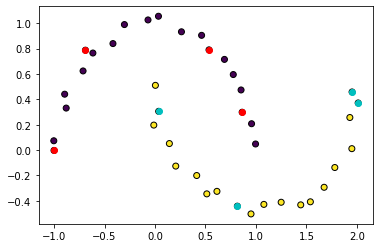

In [261]:
plt.scatter(X_initial[:,0], X_initial[:,1], c=true_labels_initial, edgecolors="k")
plt.plot(X_initial[labeled_cluster0,0],X_initial[labeled_cluster0,1],'or')
plt.plot(X_initial[labeled_cluster1,0],X_initial[labeled_cluster1,1],'oc')

In [262]:
# ===============================
# RUN ONLINE OPTIMIZATION
# ===============================
N = 4000  
mu = 1e-3
h = 4e-4
method_params = {
    'ZO-GD (Exact)': {'h': h, 'mu': mu*0.1, 'Y': 10},
    'ZO-GD (Taylor)': {'h': h*5 , 'mu': mu, 'Y': 40},  # Different parameters for Taylor
    'Subgradient (Exact)': {'h': h}  # Subgradient doesn't use mu or Y
}
function_generators = create_function_generators()
results_online = {}

print("Running online optimization...")

for method_name, func_generator in function_generators.items():
    print(f"Running {method_name}...")
    params = method_params[method_name]
    
    if 'ZO-GD' in method_name:
        ww, times = RM_online(func_generator, w0, N, 
                             h=params['h'], 
                             mu=params['mu'], 
                             proj=proj01, 
                             Y=params['Y'])
    else:  # Subgradient methods
        ww, times = submin_online(func_generator, w0, N, 
                                 h=params['h'], 
                                 proj=proj01)
    
    # Evaluate final solution on current state
    X_final = update_cluster_positions(X_initial, true_labels_initial, motion_params, N, N)
    K_final = compute_kernel(X_final)
    F_final = lambda A_bin: submodular_cost(A_bin, K_final, eta)
    
    # Evaluate trajectory (expensive but informative)
    FL_vals = []
    for k in range(0, N, 10):  # Sample every 10 iterations to reduce computation
        X_k = update_cluster_positions(X_initial, true_labels_initial, motion_params, k, N)
        K_k = compute_kernel(X_k)
        F_k = lambda A_bin: submodular_cost(A_bin, K_k, eta)
        FL_k = lambda w: lovasz_extension(F_k, V, w)
        FL_vals.append(FL_k(ww[:, k]))
    
    results_online[method_name] = (ww, FL_vals, times[::10])  # Store sampled results

Running online optimization...
Running ZO-GD (Exact)...
Running ZO-GD (Taylor)...
Running Subgradient (Exact)...


In [263]:
# ===============================
# RESULTS AND VISUALIZATION
# ===============================
print("\n" + "="*50)
print("ONLINE OPTIMIZATION RESULTS")
print("="*50)

# Evaluate final solutions
for method_name, (ww, FL_vals, times) in results_online.items():
    X_final = update_cluster_positions(X_initial, true_labels_initial, motion_params, N, N)
    K_final = compute_kernel(X_final)
    F_final = lambda A_bin: submodular_cost(A_bin, K_final, eta)
    
    w_final = ww[:, -1]
    A_bin, F_val = round_solution(w_final, F_final)
    
    print(f"{method_name:25s}: Final Cost = {F_val:8.4f} Time(s) = {times[-1]: 8.4f}")


ONLINE OPTIMIZATION RESULTS
ZO-GD (Exact)            : Final Cost =  22.2732 Time(s) =  257.0688
ZO-GD (Taylor)           : Final Cost =  22.2732 Time(s) =  18.5895
Subgradient (Exact)      : Final Cost =  22.2732 Time(s) =  13.4902


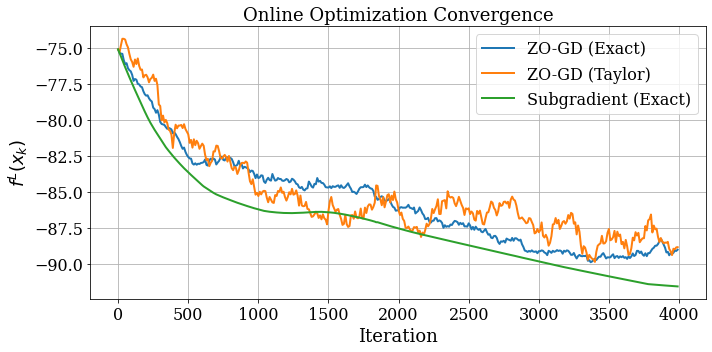

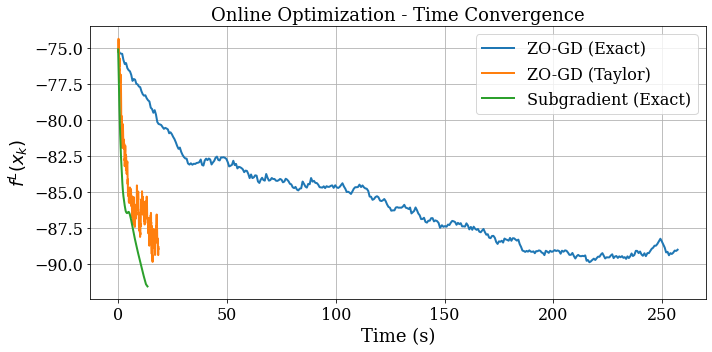

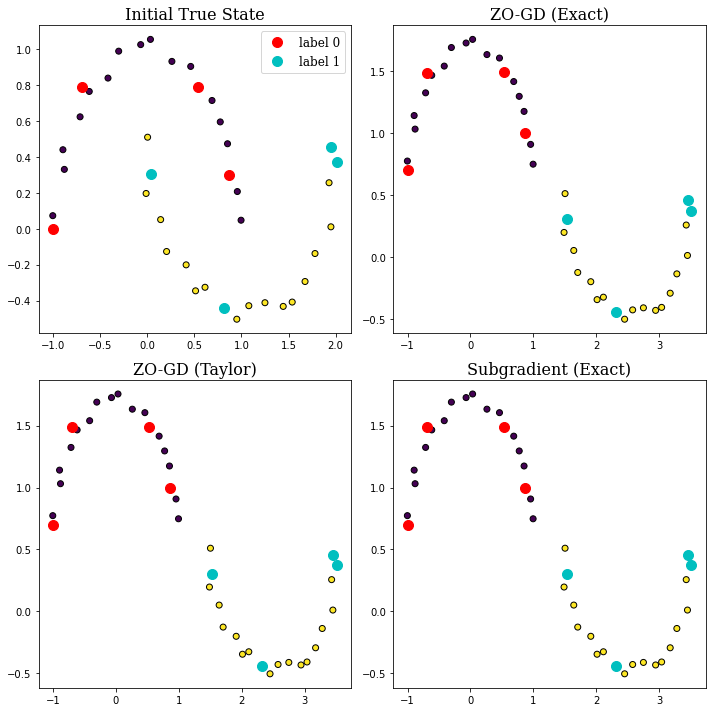

In [264]:
# Plot convergence in online setting
font = {'family': 'serif', 'color': 'black', 'weight': 'normal', 'size': 18}
font1 = {'family': 'serif', 'size': 16}

plt.figure(figsize=(10, 5))
plt.xticks(fontname='serif', fontsize=16, color='black')
plt.yticks(fontname='serif', fontsize=16, color='black')

for method_name, (_, FL_vals, _) in results_online.items():
    iterations = np.arange(0, N, 10)
    plt.plot(iterations, FL_vals, label=method_name, linewidth=2)

plt.title('Online Optimization Convergence', fontdict=font)
plt.xlabel('Iteration', fontdict=font)
plt.ylabel(r'$f^L(x_k)$', fontdict=font)
plt.grid(True)
plt.legend(loc='best', prop=font1)
plt.tight_layout()
plt.savefig('online_convergence.pdf', format='pdf', bbox_inches='tight')

# Plot time convergence
plt.figure(figsize=(10, 5))
plt.xticks(fontname='serif', fontsize=16, color='black')
plt.yticks(fontname='serif', fontsize=16, color='black')

for method_name, (_, FL_vals, times) in results_online.items():
    plt.plot(times, FL_vals, label=method_name, linewidth=2)

plt.title('Online Optimization - Time Convergence', fontdict=font)
plt.xlabel('Time (s)', fontdict=font)
plt.ylabel(r'$f^L(x_k)$', fontdict=font)
plt.grid(True)
plt.legend(loc='best', prop=font1)
plt.tight_layout()
plt.savefig('online_time_convergence.pdf', format='pdf', bbox_inches='tight')

# Visualize cluster movement and final results

font = {'family': 'serif', 'color':  'black', 'weight': 'normal', 'size': 16}
font1 = {'family': 'serif', 'size': 12}
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
X_initial_plot = X_initial.copy()
X_mid_plot = update_cluster_positions(X_initial, true_labels_initial, motion_params, N//3, N)
X_final_plot = update_cluster_positions(X_initial, true_labels_initial, motion_params, N, N)

# Function to plot with labeled points
def plot_with_labels(ax, X, true_labels, method_name=None):
    # Plot all points
    scatter = ax.scatter(X[:, 0], X[:, 1], c=true_labels, edgecolors="k")
    
    # Highlight labeled points with different markers
    ax.plot(X[labeled_cluster0, 0], X[labeled_cluster0, 1], 'or', markersize=10, label='label 0')
    ax.plot(X[labeled_cluster1, 0], X[labeled_cluster1, 1], 'oc', markersize=10, label='label 1')
    
    if method_name:
        ax.set_title(f'{method_name}',fontdict=font)
    return scatter

# Initial state
plot_with_labels(axes[0, 0], X_initial_plot, true_labels_initial)
axes[0, 0].set_title('Initial True State',fontdict=font)
axes[0, 0].legend(loc='best', prop=font1)

# Intermediate state
# plot_with_labels(axes[0, 1], X_mid_plot, true_labels_initial)
# axes[0, 1].set_title(f'Intermediate State (iter {N//3})')

# # Final state
# plot_with_labels(axes[0, 2], X_final_plot, true_labels_initial)
# axes[0, 2].set_title(f'Final State (iter {N})')

# Plot final clusterings from different methods
methods_to_plot = list(results_online.keys()) 
for i, method_name in enumerate(methods_to_plot):
    ww, _, _ = results_online[method_name]
    w_final = ww[:, -1]
    A_bin, _ = round_solution(w_final, F_final)
    if i ==0:
        row = 0
        col = i+1
    else:
        row=1
        col = i-1
    plot_with_labels(axes[row, col], X_final_plot, A_bin, method_name)

plt.tight_layout()
plt.savefig('online_clusters.pdf', format='pdf', bbox_inches='tight')
plt.show()

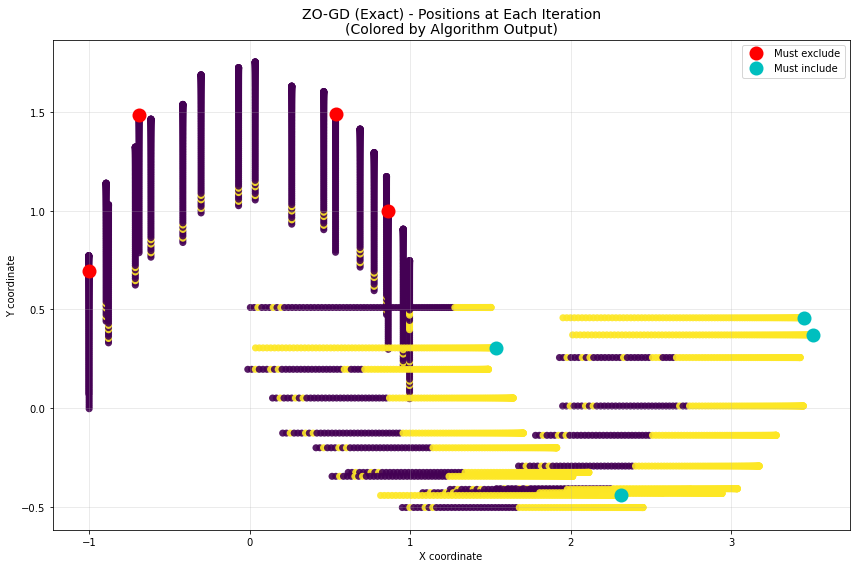

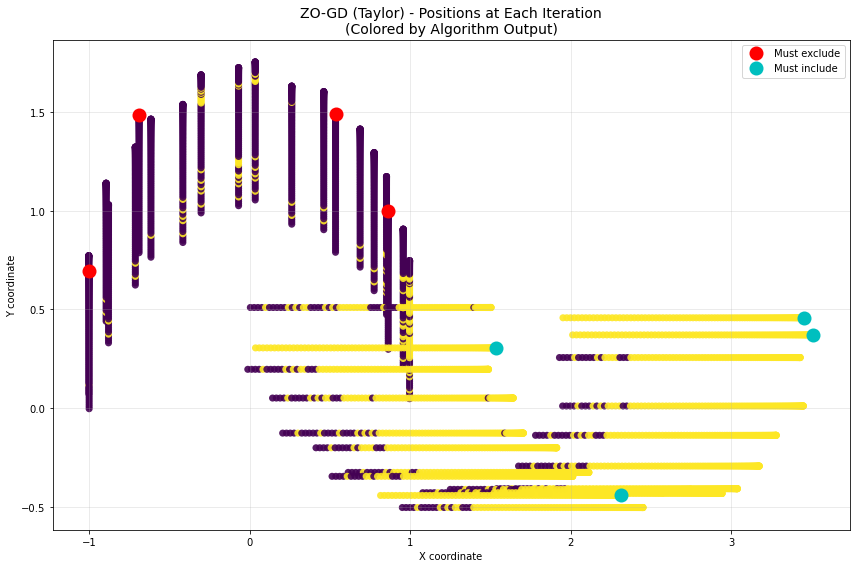

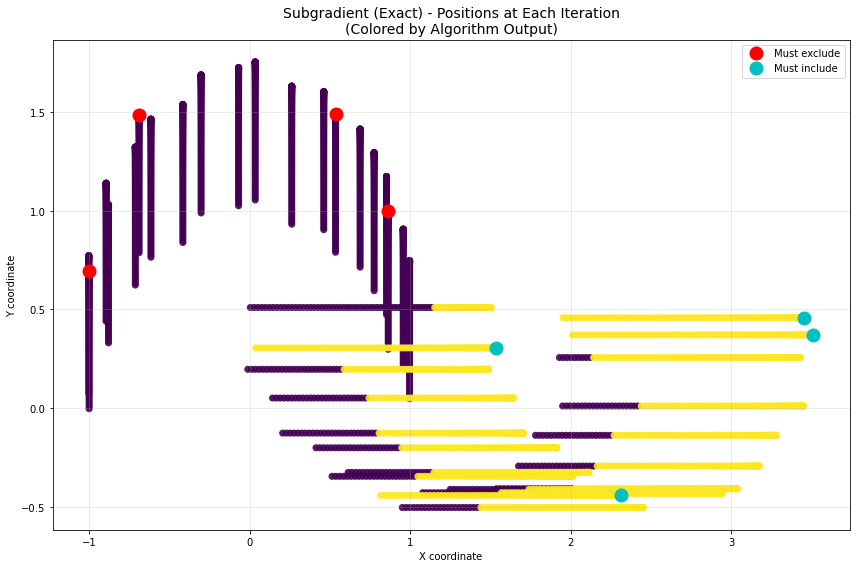

In [265]:
# Plot trajectory for each method showing positions at each iteration with current labels
for method_name, (ww, FL_vals, _) in results_online.items():
    plt.figure(figsize=(12, 8))
    
    # Sample iterations to plot (use fewer for clarity)
    sample_iterations = np.linspace(0, N, min(100, N), dtype=int)
    
    for iter_idx in sample_iterations:
        # Get current positions
        X_current = update_cluster_positions(X_initial, true_labels_initial, motion_params, iter_idx, N)
        
        # Get current kernel and cost function
        K_current = compute_kernel(X_current)
        F_current = lambda A_bin: submodular_cost(A_bin, K_current, eta)
        
        # Get algorithm's current labeling
        w_current = ww[:, iter_idx]
        A_bin_current, _ = round_solution(w_current, F_current)
        
        # Plot points with current algorithm labels
        plt.scatter(X_current[:, 0], X_current[:, 1], 
                   c=A_bin_current, 
                   alpha=0.9, 
                   s=50,
                   edgecolors='k',
                   linewidth=0.0)
        
        # # Add iteration number
        # center_x = np.mean(X_current[:, 0])
        # center_y = np.mean(X_current[:, 1])
        # plt.text(center_x, center_y, f'{iter_idx}', 
        #         fontsize=10, ha='center', va='center',
        #         bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.8))
    
    # Add final labeled constraints for reference
    X_final = update_cluster_positions(X_initial, true_labels_initial, motion_params, N, N)
    plt.plot(X_final[labeled_cluster0, 0], X_final[labeled_cluster0, 1], 
             'or', markersize=12, label='Must exclude', markeredgewidth=2)
    plt.plot(X_final[labeled_cluster1, 0], X_final[labeled_cluster1, 1], 
             'oc', markersize=12, label='Must include', markeredgewidth=2)
    
    plt.title(f'{method_name} - Positions at Each Iteration\n(Colored by Algorithm Output)', fontsize=14)
    plt.xlabel('X coordinate')
    plt.ylabel('Y coordinate')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(f'iterations_{method_name.replace(" ", "_").replace("(", "").replace(")", "")}.pdf', 
                format='pdf', bbox_inches='tight')
    plt.show()

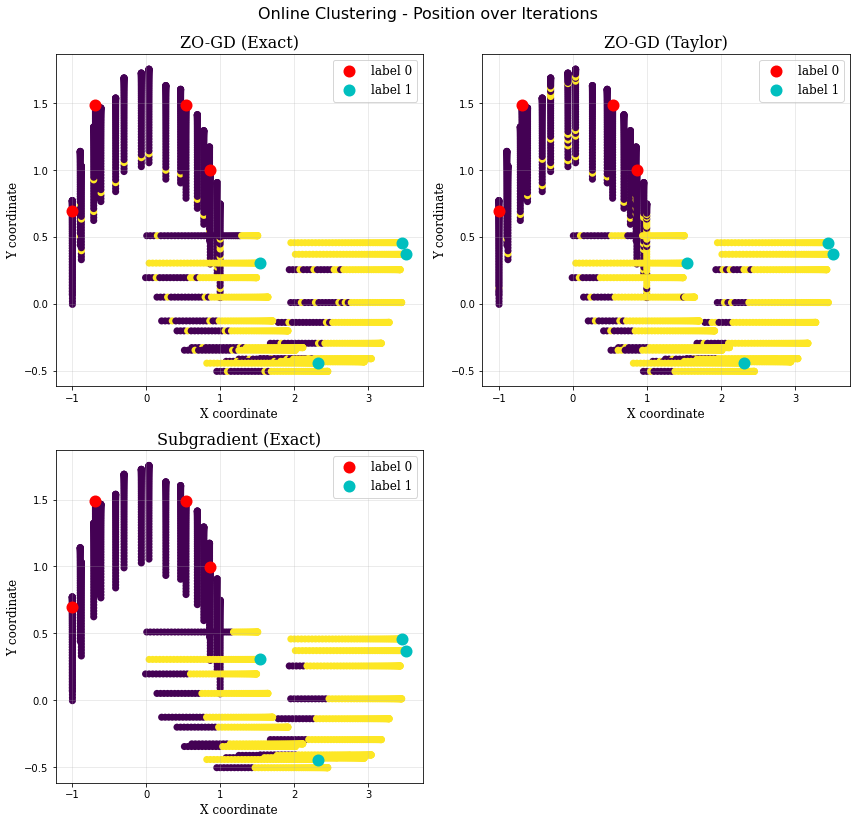

In [266]:
font = {'family': 'serif', 'color':  'black', 'weight': 'normal', 'size': 16}
font1 = {'family': 'serif', 'size': 12}
# Create figure with 2x2 subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 12))

# Flatten axes for easy iteration
axes_flat = axes.flatten()

# Plot each method in its own subplot
for i, (method_name, (ww, FL_vals, _)) in enumerate(results_online.items()):
    if i >= 4:  # Only plot first 4 methods (2x2 grid)
        break
        
    ax = axes_flat[i]
    
    # Sample iterations to plot
    sample_iterations = np.linspace(0, N, min(50, N), dtype=int)
    
    for iter_idx in sample_iterations:
        # Get current positions
        X_current = update_cluster_positions(X_initial, true_labels_initial, motion_params, iter_idx, N)
        
        # Get current kernel and cost function
        K_current = compute_kernel(X_current)
        F_current = lambda A_bin: submodular_cost(A_bin, K_current, eta)
        
        # Get algorithm's current labeling
        w_current = ww[:, iter_idx]
        A_bin_current, _ = round_solution(w_current, F_current)
        
        # Plot points with current algorithm labels
        ax.scatter(X_current[:, 0], X_current[:, 1], 
                   c=A_bin_current, 
                   alpha=1.0, 
                   s=50,
                   edgecolors='k',
                   linewidth=0.00)
    
    # Add final labeled constraints for reference
    X_final = update_cluster_positions(X_initial, true_labels_initial, motion_params, N, N)
    ax.plot(X_final[labeled_cluster0, 0], X_final[labeled_cluster0, 1], 
             'or', markersize=10, label='label 0', markeredgewidth=2)
    ax.plot(X_final[labeled_cluster1, 0], X_final[labeled_cluster1, 1], 
             'oc', markersize=10, label='label 1', markeredgewidth=2)
    
    ax.set_title(f'{method_name}', fontdict=font)
    ax.set_xlabel('X coordinate',fontdict=font1)
    ax.set_ylabel('Y coordinate',fontdict=font1)
    ax.legend(loc='best', prop=font1)
    ax.grid(True, alpha=0.3)

# Remove empty subplot if we have less than 4 methods
for i in range(len(results_online), 4):
    axes_flat[i].set_visible(False)

plt.suptitle('Online Clustering - Position over Iterations\n\n', 
             fontsize=16, y=0.95)
plt.tight_layout()
plt.savefig('all_methods_iterations.pdf', format='pdf', bbox_inches='tight')
plt.show()

Below three animations of the clustering over iterations of the three different methods are created. The animations are uploaded in the Git repository.

In [268]:
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation

# Create animation for each method
for method_name, (ww, FL_vals, _) in results_online.items():
    fig, ax = plt.subplots(figsize=(10, 8))
    
    ax.set_xticks([])
    ax.set_yticks([])
    # Sample more iterations for smoother animation
    sample_iterations = np.linspace(0, N, min(400, N), dtype=int)
    
    # Precompute all positions and labels for efficiency
    all_positions = []
    all_labels = []
    all_labeled_positions_0 = []  # For must-exclude points
    all_labeled_positions_1 = []  # For must-include points
    
    print(f"Precomputing data for {method_name} animation...")
    for iter_idx in sample_iterations:
        # Get current positions
        X_current = update_cluster_positions(X_initial, true_labels_initial, motion_params, iter_idx, N)
        
        # Get current positions of labeled points
        labeled_positions_0 = X_current[labeled_cluster0]  # Must exclude
        labeled_positions_1 = X_current[labeled_cluster1]  # Must include
        
        # Get current kernel and cost function
        K_current = compute_kernel(X_current)
        F_current = lambda A_bin: submodular_cost(A_bin, K_current, eta)
        
        # Get algorithm's current labeling
        w_current = ww[:, iter_idx]
        A_bin_current, _ = round_solution(w_current, F_current)
        
        all_positions.append(X_current)
        all_labels.append(A_bin_current)
        all_labeled_positions_0.append(labeled_positions_0)
        all_labeled_positions_1.append(labeled_positions_1)
    
    # Initialize scatter plots
    scatter = ax.scatter([], [], s=60, edgecolors='k', linewidth=0.8)
    scatter_labeled_0 = ax.scatter([], [], s=100, marker='o', facecolors='none', 
                                  edgecolors='red', linewidth=3, label='label 0')
    scatter_labeled_1 = ax.scatter([], [], s=100, marker='s', facecolors='none', 
                                  edgecolors='blue', linewidth=3, label='label 1')
    
    # Add iteration text
    iter_text = ax.text(0.02, 0.98, '', transform=ax.transAxes, fontsize=14,
                       bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.8))
    
    # Set up the animation
    def init():
        scatter.set_offsets(np.empty((0, 2)))
        scatter_labeled_0.set_offsets(np.empty((0, 2)))
        scatter_labeled_1.set_offsets(np.empty((0, 2)))
        iter_text.set_text('')
        return scatter, scatter_labeled_0, scatter_labeled_1, iter_text
    
    def update(frame):
        # Get data for current frame
        X_current = all_positions[frame]
        labels_current = all_labels[frame]
        labeled_0_current = all_labeled_positions_0[frame]
        labeled_1_current = all_labeled_positions_1[frame]
        iter_idx = sample_iterations[frame]
        
        # Update scatter plots
        scatter.set_offsets(X_current)
        scatter.set_array(labels_current)
        scatter.set_cmap('viridis')
        
        scatter_labeled_0.set_offsets(labeled_0_current)
        scatter_labeled_1.set_offsets(labeled_1_current)
        
        # Update iteration text
        iter_text.set_text(f'Iteration: {iter_idx}/{N}')
        
        # Update plot limits dynamically
        ax.set_xlim(X_current[:, 0].min() - 0.5, X_current[:, 0].max() + 0.5)
        ax.set_ylim(X_current[:, 1].min() - 0.5, X_current[:, 1].max() + 0.5)
        
        return scatter, scatter_labeled_0, scatter_labeled_1, iter_text
    
    # Create animation
    anim = FuncAnimation(fig, update, frames=len(sample_iterations),
                        init_func=init, blit=True, interval=50)  # 50ms between frames
    
    ax.set_title(f'{method_name} - Online Clustering Evolution', fontsize=16)
    ax.set_xlabel('X coordinate', fontdict=font1)
    ax.set_ylabel('Y coordinate', fontdict=font1)
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Save animation
    print(f"Saving animation for {method_name}...")
    anim.save(f'animation_{method_name.replace(" ", "_").replace("(", "").replace(")", "")}.gif', 
              writer='pillow', fps=50, dpi=100)
    
    plt.close(fig)  # Close the figure to free memory
    print(f"Animation saved for {method_name}")

print("All animations completed!")

Precomputing data for ZO-GD (Exact) animation...
Saving animation for ZO-GD (Exact)...
Animation saved for ZO-GD (Exact)
Precomputing data for ZO-GD (Taylor) animation...
Saving animation for ZO-GD (Taylor)...
Animation saved for ZO-GD (Taylor)
Precomputing data for Subgradient (Exact) animation...
Saving animation for Subgradient (Exact)...
Animation saved for Subgradient (Exact)
All animations completed!
